In [1]:
import xarray as xr
from nais.utils import remove_bad_data

nais1 = xr.open_dataset("/home/coliewo/Desktop/DATA/CNR/cnr_sep_oct.nc")
bad_data1 = xr.open_dataset("/home/coliewo/Desktop/DATA/CNR/cnr_sep_oct_bad_data_bounds.nc")
nais1 = remove_bad_data(nais1, bad_data1)

nais2 = xr.open_dataset("/home/coliewo/Desktop/DATA/CNR/cnr_may_aug.nc")
bad_data2 = xr.open_dataset("/home/coliewo/Desktop/DATA/CNR/cnr_may_aug_bad_data_bounds.nc")
nais2 = remove_bad_data(nais2, bad_data2)

# Concatenate along a specific dimension, such as 'time'
complete_nais = xr.concat([nais2, nais1], dim="time")
complete_nais.to_netcdf(path='/home/coliewo/Desktop/DATA/CNR/nais_may_oct.nc')

/home/coliewo/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/coliewo/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
/home/coliewo/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/tmp/ipykernel_13012/948893749.py:14: SerializationWarning: saving variable neg_ion_flags with floating point data as an integer dtype without 

In [2]:
nais = xr.open_dataset("/home/coliewo/Desktop/DATA/CNR/nais_may_oct.nc")
nais

<xarray.Dataset>
Dimensions:             (diameter: 55, flag: 102, time: 3986)
Coordinates:
  * diameter            (diameter) float64 8.029e-10 8.628e-10 ... 4.155e-08
  * flag                (flag) <U61 '+ postfilter voltage may be too high' .....
  * time                (time) datetime64[ns] 2024-05-17 ... 2024-10-30
Data variables:
    neg_ions            (time, diameter) float64 ...
    pos_ions            (time, diameter) float64 ...
    neg_particles       (time, diameter) float64 ...
    pos_particles       (time, diameter) float64 ...
    neg_ion_flags       (time, flag) int64 ...
    pos_ion_flags       (time, flag) int64 ...
    neg_particle_flags  (time, flag) int64 ...
    pos_particle_flags  (time, flag) int64 ...
Attributes: (12/14)
    measurement_location:            CNR Bologna
    description:                     Rooftop Measurements
    longitude:                       11.34
    latitude:                        44.52
    inlet_length:                    0.85
    do_inlet_loss_correction:        True
    ...                              ...
    remove_corona_ions:              True
    fill_temperature:                273.15
    fill_pressure:                   101325.0
    fill_flowrate:                   54.0
    dilution_on:                     False
    resolution:                      5min

In [4]:
import numpy as np
# Replace negative values with NaN across all variables in the dataset
for var in nais.data_vars:
    nais[var] = nais[var].where(nais[var] >= 0, other=np.nan)

nais


<xarray.Dataset>
Dimensions:             (diameter: 55, flag: 102, time: 3986)
Coordinates:
  * diameter            (diameter) float64 8.029e-10 8.628e-10 ... 4.155e-08
  * flag                (flag) <U61 '+ postfilter voltage may be too high' .....
  * time                (time) datetime64[ns] 2024-05-17 ... 2024-10-30
Data variables:
    neg_ions            (time, diameter) float64 nan nan nan ... 1.969e+03 nan
    pos_ions            (time, diameter) float64 nan nan nan ... 1.815e+03 nan
    neg_particles       (time, diameter) float64 nan nan ... 8.7e+03 8.971e+03
    pos_particles       (time, diameter) float64 nan nan ... 1.439e+04 1.408e+04
    neg_ion_flags       (time, flag) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    pos_ion_flags       (time, flag) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    neg_particle_flags  (time, flag) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
    pos_particle_flags  (time, flag) float64 0.0 0.0 0.0 0.0 ... nan nan nan nan
Attributes: (12/14)
    measurement_location:            CNR Bologna
    description:                     Rooftop Measurements
    longitude:                       11.34
    latitude:                        44.52
    inlet_length:                    0.85
    do_inlet_loss_correction:        True
    ...                              ...
    remove_corona_ions:              True
    fill_temperature:                273.15
    fill_pressure:                   101325.0
    fill_flowrate:                   54.0
    dilution_on:                     False
    resolution:                      5min

In [5]:
# Extract the necessary variables
neg_ions = nais['neg_ions']
pos_ions = nais['pos_ions']

# Calculate particles (positive + negative particles)
particles = nais['pos_particles'] + nais['neg_particles']

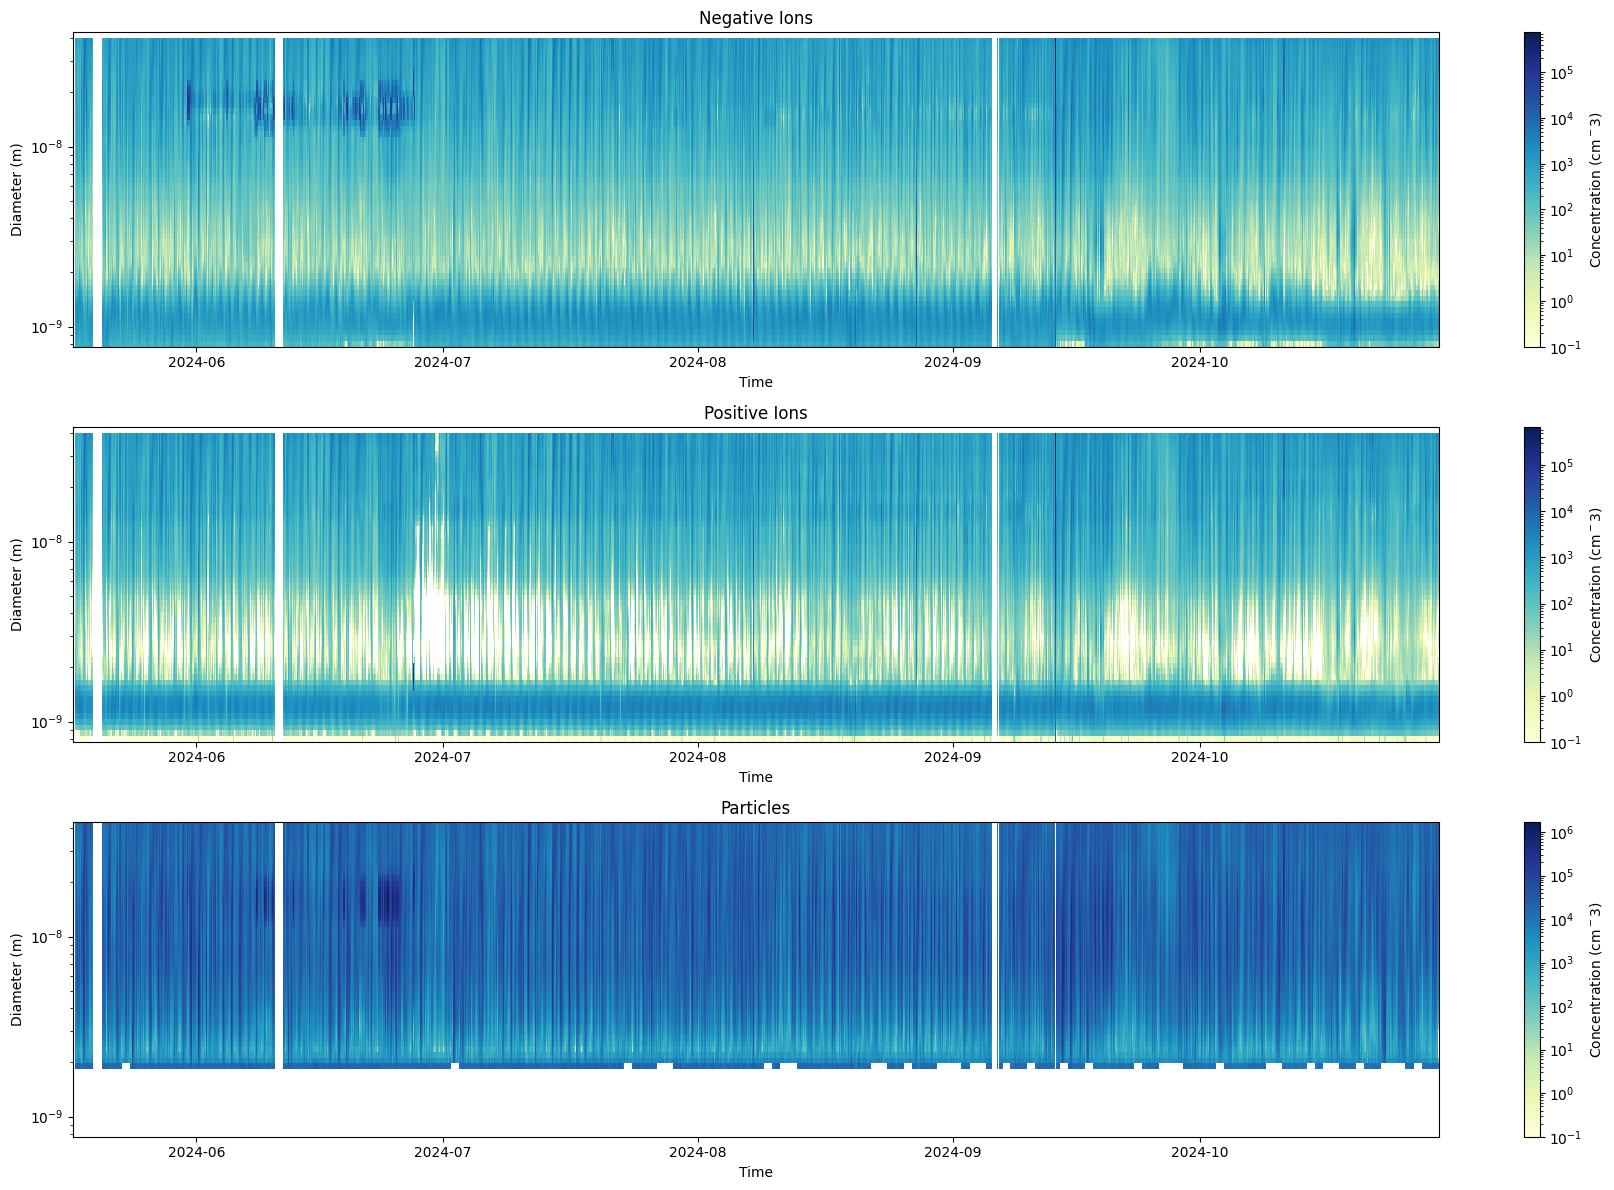

In [8]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Function to plot the complete_nais with non-negative colorbars
def plot_spectral_data(var, title, ax):
    # Apply log normalization for colorbar
    log_norm = mcolors.LogNorm(vmin= 1e-1,  # Avoid log(0)
                           vmax=var.max())
    # Plot the contour
    c = ax.pcolormesh(var['time'], var['diameter'], var.T, shading='auto', cmap='YlGnBu',norm=log_norm)
    
    # Set up the colorbar
    cbar = plt.colorbar(c, ax=ax, label='Concentration (cm$^-3$)')
    #cbar.set_label('Concentration (cm$^-3$)')
    ax.set_yscale('log')
    ax.set_xlabel('Time')
    ax.set_ylabel('Diameter (m)')
    ax.set_title(title)

# Set up the plots
fig, axs = plt.subplots(3, 1, figsize=(18, 12))

plot_spectral_data(neg_ions, 'Negative Ions', axs[0])
plot_spectral_data(pos_ions, 'Positive Ions', axs[1])
plot_spectral_data(particles, 'Particles', axs[2])

plt.tight_layout()
plt.show()

## Nanoparticle Ranking 

In [9]:
# Step 1: Extract data for the diameter range required 2.5-5nm
sub_5nm = particles.sel(diameter=slice(2.5e-9, 5e-9)) 
sub_5nm

<xarray.DataArray (time: 3986, diameter: 10)>
array([[          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       ...,
       [ 549.16129622,  740.96409975,  882.55540649, ..., 3149.18228927,
        3732.82374482, 4351.42074672],
       [ 922.58062613,  890.90491267,  843.1636855 , ..., 2910.822483  ,
        3435.97203699, 4019.98079116],
       [   0.        ,    0.        ,    0.        , ..., 1924.39380816,
        2422.65495106, 2668.05344586]])
Coordinates:
  * diameter  (diameter) float64 2.545e-09 2.736e-09 ... 4.538e-09 4.879e-09
  * time      (time) datetime64[ns] 2024-05-17 ... 2024-10-30

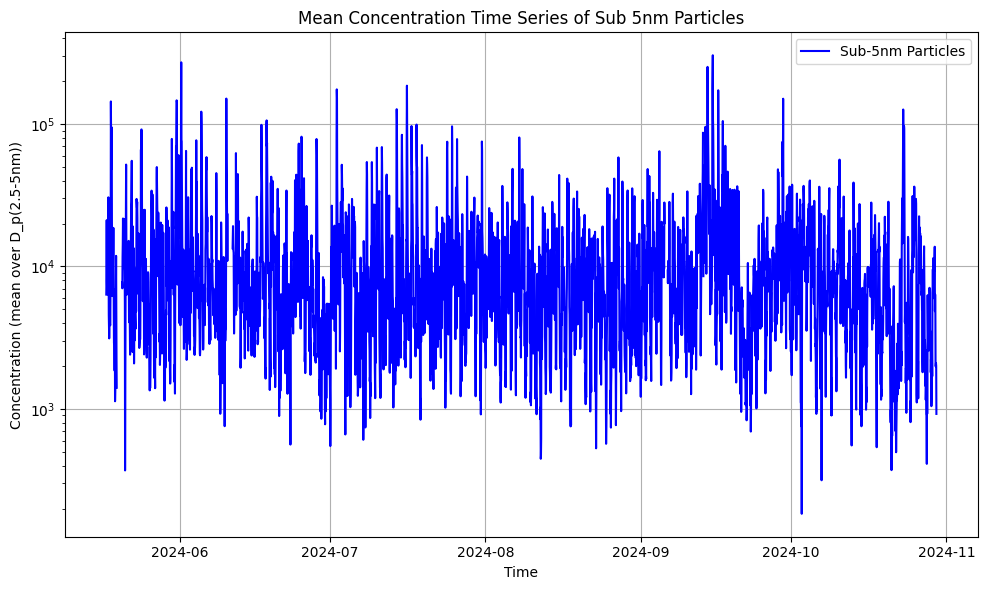

In [10]:
# Plot for sub-5nm particles

# Mean across the diameter dimension to get mean concentrations
sub_5nm_mean = sub_5nm.mean(dim='diameter')

plt.figure(figsize=(10, 6))
plt.plot(sub_5nm['time'].values, sub_5nm_mean, label='Sub-5nm Particles', color='blue')

# Customize the plot for ions
plt.title('Mean Concentration Time Series of Sub 5nm Particles')
plt.xlabel('Time')
plt.ylabel('Concentration (mean over D_p(2.5-5nm))')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

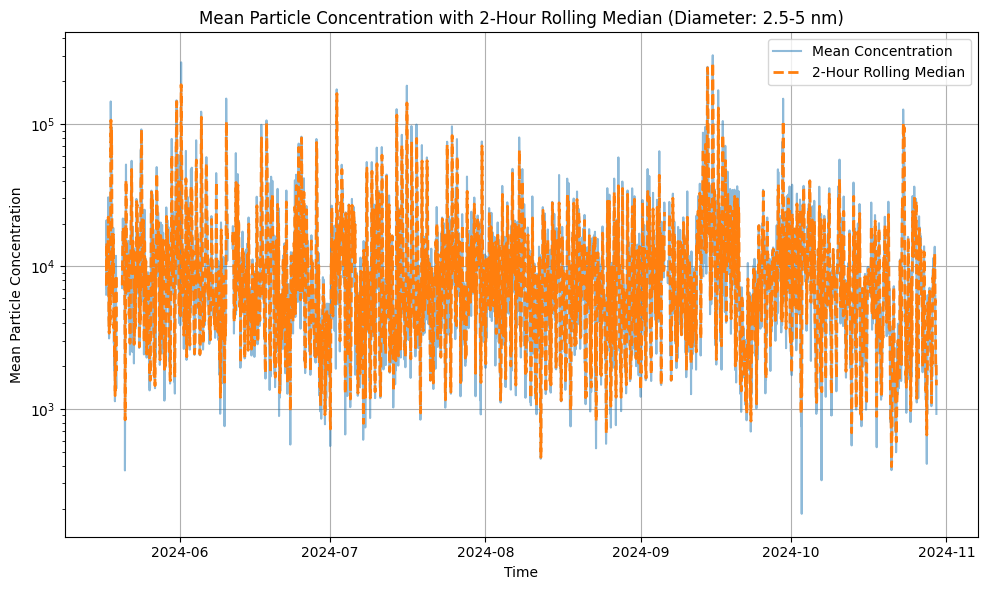

In [15]:
# Calculate a 2-hour rolling median for trend visualization
sub5nm_rollingmed = sub_5nm_mean.rolling(time=2, center=True).median()

# Plot the cleaned mean concentration and its 2-hour rolling median
plt.figure(figsize=(10, 6))
plt.plot(sub_5nm['time'].values, sub_5nm_mean, label='Mean Concentration', alpha=0.5)
plt.plot(sub5nm_rollingmed['time'].values, sub5nm_rollingmed, label='2-Hour Rolling Median', linewidth=2, linestyle='--')
plt.yscale('log')
plt.title('Mean Particle Concentration with 2-Hour Rolling Median (Diameter: 2.5-5 nm)')
plt.xlabel('Time')
plt.ylabel('Mean Particle Concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
# subdivide the data to the months
may = sub5nm_rollingmed.sel(time=slice('2024-05', '2024-05'))
june = sub5nm_rollingmed.sel(time=slice('2024-06', '2024-06'))
july = sub5nm_rollingmed.sel(time=slice('2024-07', '2024-07'))
aug = sub5nm_rollingmed.sel(time=slice('2024-08', '2024-08'))
sep = sub5nm_rollingmed.sel(time=slice('2024-09', '2024-09'))
oct = sub5nm_rollingmed.sel(time=slice('2024-10', '2024-10'))

In [13]:
# Step 3: Now, calculate diurnal variations, e.g., the mean across each hour for each month
may_diurnal_variation = may.groupby(may.time.dt.hour).mean(dim='time')
june_diurnal_variation = june.groupby(june.time.dt.hour).mean(dim='time')
july_diurnal_variation = july.groupby(july.time.dt.hour).mean(dim='time')
aug_diurnal_variation = aug.groupby(aug.time.dt.hour).mean(dim='time')
sep_diurnal_variation = sep.groupby(sep.time.dt.hour).mean(dim='time')
oct_diurnal_variation = oct.groupby(oct.time.dt.hour).mean(dim='time')

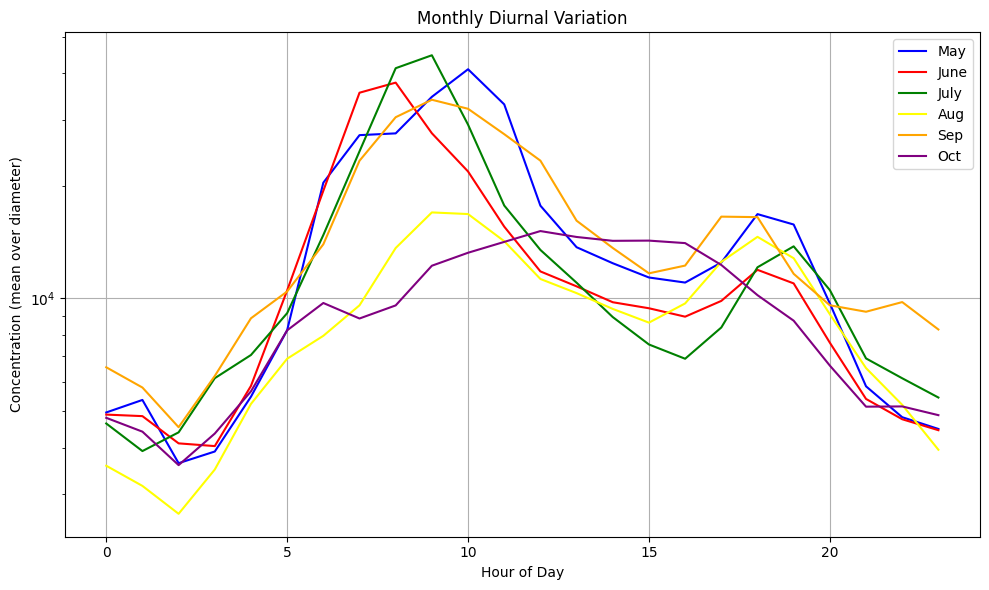

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(may_diurnal_variation['hour'], may_diurnal_variation, label='May', color='blue')
plt.plot(june_diurnal_variation['hour'], june_diurnal_variation, label='June', color='red')
plt.plot(july_diurnal_variation['hour'], july_diurnal_variation, label='July', color='green')
plt.plot(aug_diurnal_variation['hour'], aug_diurnal_variation, label='Aug', color='yellow')
plt.plot(sep_diurnal_variation['hour'], sep_diurnal_variation, label='Sep', color='orange')
plt.plot(oct_diurnal_variation['hour'], oct_diurnal_variation, label='Oct', color='purple')

# Customize the plot for ions
plt.title('Monthly Diurnal Variation')
plt.xlabel('Hour of Day')
plt.ylabel('Concentration (mean over diameter)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Define background and active regions based on time
sub5nm_rollingmed['hour'] = sub5nm_rollingmed['time'].dt.hour

# Filter for background (01:00-03:00) and active (06:00-12:00) regions
background_data = sub5nm_rollingmed[(sub5nm_rollingmed['hour'] >= 1) & (sub5nm_rollingmed['hour'] <= 3)]
active_data = sub5nm_rollingmed[(sub5nm_rollingmed['hour'] >= 6) & (sub5nm_rollingmed['hour'] <= 12)]

background_data.head(), active_data.head()


(<xarray.DataArray (time: 5)>
 array([           nan,            nan,            nan, 10025.2540963 ,
         5102.68321556])
 Coordinates:
   * time     (time) datetime64[ns] 2024-05-17T01:00:00 ... 2024-05-18T02:00:00
     hour     (time) int64 1 2 3 1 2,
 <xarray.DataArray (time: 5)>
 array([           nan,            nan,            nan,  7324.25427915,
        14716.4034702 ])
 Coordinates:
   * time     (time) datetime64[ns] 2024-05-17T06:00:00 ... 2024-05-17T10:00:00
     hour     (time) int64 6 7 8 9 10)

In [20]:
background_data

<xarray.DataArray (time: 498)>
array([           nan,            nan,            nan, 10025.2540963 ,
        5102.68321556,  3898.81724337,  2765.14827207,  2402.99951538,
        1241.19175087,            nan,            nan,            nan,
        7401.15351304,  2903.64881431,   838.81626073,  4277.11502432,
        2889.65312901,  3335.48638105,  8194.87358716,  6947.88131832,
        4325.68476077,  8722.25030512,  8780.88206616,  3904.015182  ,
       14629.89479467,  4828.13611231,  5387.28662721,  2036.29527269,
        2062.89993911,  1587.32657964,  1862.99661447,  1457.80496562,
        8440.8827829 ,  2710.73982218,  2213.15460085,  6491.57696024,
        2525.54728272,  2780.89397464,  3150.44508069,  2854.51450349,
        1680.86639132,  1578.1113554 ,  1667.35770466,  3188.94371388,
        6574.70343022,  4635.81161409,  6578.50394842,  5860.63931197,
        4226.31488626,  6350.48337534,  5193.42097447,  2803.77911003,
        5789.75657595,  7496.80292122,  2705.9492823 ,  2880.47598142,
        3801.26806402,  2415.428908  ,  2483.48353902,  2895.12443865,
        5493.08132268,  6358.46952698,  9402.56306935,  3974.94681186,
        3292.45393687,  3056.16997809,  4521.9251725 ,  3535.39417986,
        4089.56979196,  3964.20924683,  2339.03745902,  1207.52299002,
        4458.66921947,  4050.54148334,  3279.54707316,            nan,
                  nan,            nan,  8568.16195305,  7357.79331676,
...
        9226.60983639,  6126.27070642,  3980.30571046, 11444.07473316,
        9195.6254125 ,  8454.39045596,  1172.35039703,  1110.77542107,
        1136.17700377, 14346.59058957,  2828.00156018,  1321.08066939,
        5119.44916057,  5903.09103202,  6356.49231596,  1279.64545735,
        1278.9726673 ,  2054.30102988,  1803.42854541,  1649.48411981,
        3896.79699117,  6218.97703041, 14964.43403149, 17134.4230667 ,
        2975.41843391,  3059.73259903,  3259.27012896,  1054.10805503,
         680.42581889,   873.90327601,  2119.22179089,  3859.62877198,
        4215.95973608,  1061.90507637,   845.31624587,  1330.68026806,
        1270.68634168,  1132.8912976 ,  2737.06843758, 18943.73379284,
        9526.50797063,  7382.59303795,  1721.81968921,   886.28837024,
        1957.39720963,  1309.89901326,  1241.54286175,  1782.50703255,
        8669.42524341,  4051.53899506,  4905.004073  ,   393.98154302,
         428.81508011,   695.84260238,   764.8807012 ,   987.74287598,
        1128.74887172,  2277.65327881,  7730.05826289, 17130.84529529,
        2724.2926083 ,  5037.59864173,  3745.41632422,  7874.05596857,
        3992.33210828,  2347.21135517,  7190.70935674,  1187.2356914 ,
        2431.38164151,  6387.10560719,  6581.5745649 ,  5820.0169463 ,
         910.29573086,   656.60640927,  1492.62286936,  1104.36514172,
        2188.02770351,  2824.88611907])
Coordinates:
  * time     (time) datetime64[ns] 2024-05-17T01:00:00 ... 2024-10-29T03:00:00
    hour     (time) int64 1 2 3 1 2 3 1 2 3 1 2 3 1 ... 1 2 3 1 2 3 1 2 3 1 2 3

In [21]:
active_data

<xarray.DataArray (time: 1162)>
array([          nan,           nan,           nan, ..., 9576.79329281,
       6848.84438173, 6135.74018633])
Coordinates:
  * time     (time) datetime64[ns] 2024-05-17T06:00:00 ... 2024-10-29T12:00:00
    hour     (time) int64 6 7 8 9 10 11 12 6 7 8 9 ... 10 11 12 6 7 8 9 10 11 12

In [25]:
background_data.groupby(background_data['time'].dt.date).median()

<xarray.DataArray (date: 166)>
array([           nan,  5102.68321556,  2402.99951538,            nan,
        2903.64881431,  3335.48638105,  6947.88131832,  8722.25030512,
        5387.28662721,  2036.29527269,  1862.99661447,  2710.73982218,
        2780.89397464,  1680.86639132,  3188.94371388,  5860.63931197,
        5193.42097447,  5789.75657595,  2880.47598142,  2483.48353902,
        6358.46952698,  3292.45393687,  4089.56979196,  2339.03745902,
        4050.54148334,            nan,  7357.79331676,  8350.61905723,
        5299.92028447,  4577.4138703 ,  6698.46090093,  8531.83967775,
        1853.70050865,  2110.30171567,  2260.04782105,  2575.01354444,
        2041.7981721 ,  2421.24433059,  4933.05147376,  6248.47872304,
        2132.68878115,  2003.22360845,  2324.54519078,  2150.17003745,
        1759.37237486,   850.04476924,  6650.3742591 , 14738.33400355,
        7327.92102575,  1685.81367538,  3995.1273702 ,  6830.97951118,
        3395.49540807,  1376.70311211,  2873.65125834,  1477.12953408,
        2888.47768194,  4854.52578225,  3233.36419631,  2628.49156359,
        3631.0217243 ,  2855.92174973,  3151.13987177,  1009.83458429,
        7500.64105346,  2011.57998772,  8124.12296845,  2697.3656509 ,
        1586.44881828,  1559.93370378, 19597.40592743,  2924.91988144,
        2857.48847179,  9506.04137452,  5982.09628475,  2745.939162  ,
        2192.16008148, 14862.17833243,  8986.03359106,  1319.11523498,
...
        1490.39517668,  2039.94884937,  1973.70516917,  1919.37896825,
        2109.48483651,  1056.05433579,  3954.0672993 ,  6109.43515224,
        1440.17198904,  2948.7095617 ,   856.46938164,  1773.5701241 ,
         780.92270152,  1101.41002987,  1352.73485424,  1697.35009618,
        1586.8131962 ,  2165.88066981,  2399.57702204,  1806.17642082,
        1664.16150029,  2338.12460683,  4827.61766397,  2278.50535048,
                  nan,  1706.18244337,  3862.54915039,  3564.92860366,
        3036.04886228,  2630.18856199,  2908.24442051,  9280.53971834,
       16762.3068908 ,  6027.37969846,  2844.99685719,  9084.64145271,
        6707.52399905,  5034.08305801,  3220.16596188,  2096.24896471,
        1708.63217984,  1855.20574669,  1138.93087962,  6416.52463434,
        4026.77991532,  4582.89899242,  8948.77131828,  6891.35967981,
       15519.3911338 ,  2110.66747202,  4402.46539776,  1230.731816  ,
        6126.27070642,  9195.6254125 ,  1136.17700377,  2828.00156018,
        5903.09103202,  1279.64545735,  1803.42854541, 14964.43403149,
        3059.73259903,   873.90327601,  3859.62877198,  1061.90507637,
        1270.68634168,  9526.50797063,  1721.81968921,  1309.89901326,
        4905.004073  ,   428.81508011,   987.74287598,  7730.05826289,
        3745.41632422,  3992.33210828,  2431.38164151,  6387.10560719,
         910.29573086,  2188.02770351])
Coordinates:
  * date     (date) object 2024-05-17 2024-05-18 ... 2024-10-28 2024-10-29

In [27]:
active_data.groupby(active_data['time'].dt.date).max()

<xarray.DataArray (date: 166)>
array([ 14716.4034702 , 106350.76867715,   8681.91516919,             nan,
        40298.44787151,  47995.23935276,  28570.97113509,  91466.23936877,
        10957.27143934,  33312.79315059,  44990.00538078,  16115.12128079,
        22464.59428642,  60631.74297632, 143680.50514075, 188564.00744723,
        41328.750391  ,  36824.39994613,  55897.23370663, 111780.95698396,
        53110.55508022,  21401.52627958,  39158.96998452,  18076.70837519,
       103741.76193622,             nan,  38860.82331249,   7519.25278808,
        12111.85023123,   6631.01355044,  26690.85231676,  79934.10132122,
       102332.04088327,  32393.76806701,  15187.45438752,   6325.19492928,
        28387.58260077,  11849.4696634 ,  36992.59494207,  79820.84727674,
        24986.8459473 ,  15131.68480606,  74149.56194782,   3520.31039499,
         5034.84582957,  25819.81221848, 163477.94019747,  47956.88494658,
        21369.86092832,  26871.93541845,   8603.16642312,   5258.35367561,
        49104.71353239,  46565.99286511,  52669.73981457,  60439.97348887,
        43045.27130942,  16386.56584198, 115555.59974675,  71051.48718124,
       140541.06986009,  75125.44840009,  79186.07335012,  54999.38438137,
        55263.18763074,   9716.58642289,  20120.8606195 ,  21570.65208938,
        71421.7371536 ,  82933.63135503,  59289.86450486,  19508.99326393,
        33651.78220058,  16249.44583509,  21244.33620894,  70197.73373616,
        11120.34940387,  15208.1291767 ,  17369.7414422 ,  32055.32671313,
...
        15421.11633701,  27960.44659223,  15988.93668057,  16295.83945967,
        32579.56532938,  17307.68806491,  29500.82002901,  14546.87176004,
        12806.23786066,  11957.16293785,  12483.63617875,  17152.29213058,
        28731.53893194,   9943.29889048,  20819.622381  ,  35276.7930669 ,
        32117.38051731,  26290.48666942,  12972.24047954,  28177.99361721,
        33614.69438608,  25369.59062805,  26034.8089372 ,  16321.73203971,
         9255.01097492,  30131.39530528,  14986.33267287,  19478.84317201,
        22146.55501814,   7321.88566156,  24561.76676298,  66507.17643741,
       247507.05649794, 268512.55892564, 129558.91586179,  84167.55337471,
        32620.79770367,  24406.92111104,  29834.68676001,   5593.58111471,
         8181.25944344,   8230.16280106,  13027.1719347 ,  33645.35968578,
        21494.97114213,  13246.10436351,  37796.39582719, 104911.19693871,
        29841.64100865,  23465.34017265,  19546.97581324,  35870.88493476,
        24927.179981  ,  21232.62613521,  13133.68755787,   8944.51132852,
        20139.24016622,  13188.63661797,  30052.09144772,  24372.50873083,
         9709.67840685,  31026.14636175,  17498.16644016,   7015.38459986,
         9574.93110561,  10743.57318045,  14730.17602353,  11011.93956295,
        23113.3299456 ,   7145.59902786,   3044.40056244, 101546.7802866 ,
        15881.17529584,  24334.12567194,  13176.37581606,   8606.37611213,
         5558.22896855,   9576.79329281])
Coordinates:
  * date     (date) object 2024-05-17 2024-05-18 ... 2024-10-28 2024-10-29

In [28]:
# Calculate the median value for each day in the background region
background_daily_median = background_data.groupby(background_data['time'].dt.date).median()

# Calculate the max value for each day in the active region
active_daily_max = active_data.groupby(active_data['time'].dt.date).max()


In [29]:
# Now calculate the daily change
daily_change = active_daily_max - background_daily_median

In [33]:
daily_change.dropna(dim='date')

<xarray.DataArray (date: 162)>
array([101248.08546159,   6278.91565381,  37394.7990572 ,  44659.75297171,
        21623.08981677,  82743.98906365,   5569.98481213,  31276.49787789,
        43127.00876632,  13404.38145862,  19683.70031179,  58950.87658501,
       140491.56142687, 182703.36813526,  36135.32941653,  31034.64337018,
        53016.75772521, 109297.47344494,  46752.08555324,  18109.07234271,
        35069.40019256,  15737.67091617,  99691.22045288,  31503.02999573,
         -831.36626915,   6811.92994676,   2053.59968014,  19992.39141583,
        71402.26164347, 100478.34037462,  30283.46635135,  12927.40656648,
         3750.18138484,  26345.78442868,   9428.22533281,  32059.54346831,
        73572.3685537 ,  22854.15716615,  13128.46119761,  71825.01675705,
         1370.14035754,   3275.47345471,  24969.76744924, 156827.56593837,
        33218.55094303,  14041.93990257,  25186.12174306,   4608.03905292,
        -1572.62583557,  45709.21812432,  45189.289753  ,  49796.08855623,
        58962.84395479,  40156.79362748,  11532.04005973, 112322.23555045,
        68422.99561765, 136910.04813579,  72269.52665036,  76034.93347834,
        53989.54979708,  47762.54657728,   7705.00643517,  11996.73765105,
        18873.28643848,  69835.28833533,  81373.69765125,  39692.45857743,
        16584.07338248,  30794.29372879,   6743.40446057,  15262.2399242 ,
        67451.79457416,   8928.18932239,    345.95084427,   8383.70785115,
        30736.21147815,  24837.60433832,  40711.94876043,  17080.31062064,
...
        24281.1655791 ,  13930.72116033,  25920.49774286,  14015.23151141,
        14376.46049143,  30470.08049286,  16251.63372912,  25546.75272971,
         8437.4366078 ,  11366.06587161,   9008.45337615,  11627.16679711,
        15378.72200648,  27950.61623042,   8841.88886062,  19466.88752675,
        33579.44297072,  30530.56732112,  24124.6059996 ,  10572.66345751,
        26371.81719639,  31950.53288578,  23031.46602122,  21207.19127322,
        14043.22668924,  28425.21286191,  11123.78352249,  15913.91456835,
        19110.50615586,   4691.69709957,  21653.52234247,  57226.63671907,
       230744.74960713, 262485.17922718, 126713.9190046 ,  75082.911922  ,
        25913.27370463,  19372.83805303,  26614.52079813,   3497.33215   ,
         6472.62726359,   6374.95705437,  11888.24105508,  27228.83505144,
        17468.19122681,   8663.20537109,  28847.6245089 ,  98019.8372589 ,
        14322.24987484,  21354.67270063,  15144.51041548,  34640.15311876,
        18800.90927459,  12037.00072271,  11997.5105541 ,   6116.50976833,
        14236.14913421,  11908.99116062,  28248.66290231,   9408.07469935,
         6649.94580782,  30152.24308574,  13638.53766818,   5953.47952349,
         8304.24476393,   1217.06520982,  13008.35633432,   9702.0405497 ,
        18208.3258726 ,   6716.78394775,   2056.65768646,  93816.72202371,
        12135.75897162,  20341.79356367,  10744.99417455,   2219.27050494,
         4647.93323769,   7388.7655893 ])
Coordinates:
  * date     (date) object 2024-05-18 2024-05-19 ... 2024-10-28 2024-10-29

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


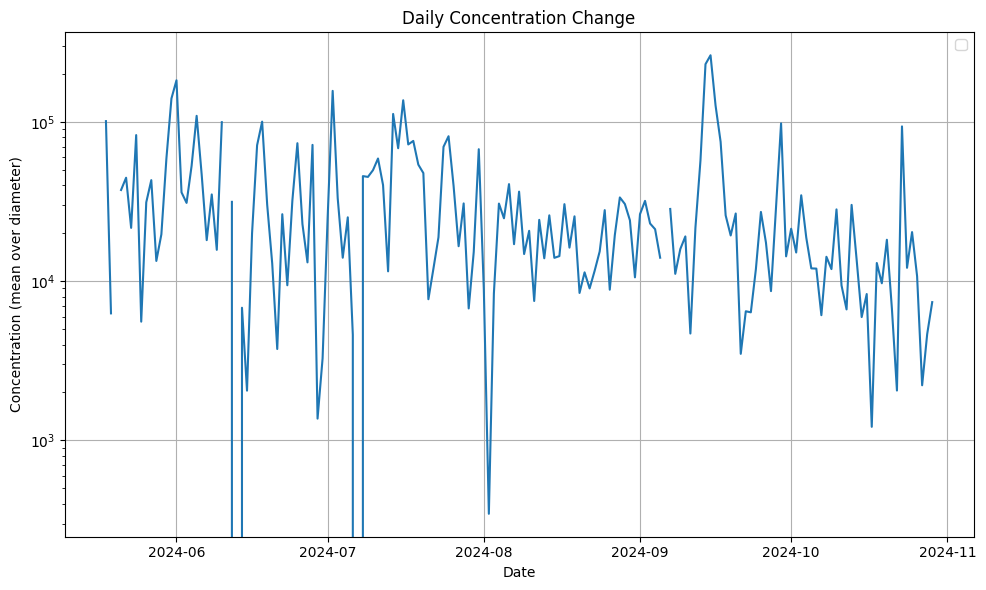

In [31]:
plt.figure(figsize=(10, 6))

plt.plot(daily_change['date'], daily_change)

# Customize the plot for ions
plt.title('Daily Concentration Change')
plt.xlabel('Date')
plt.ylabel('Concentration (mean over diameter)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


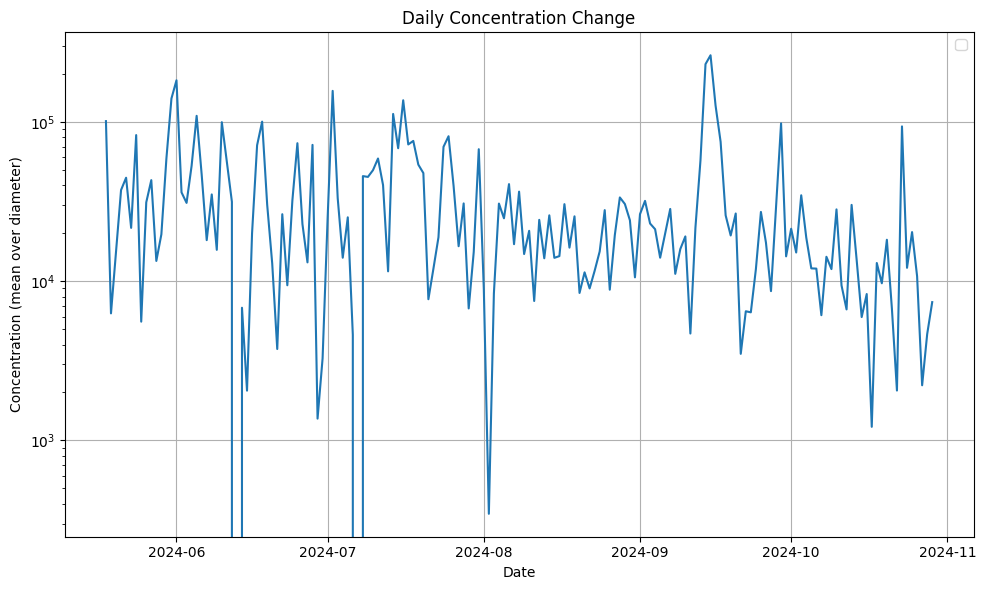

In [34]:
plt.figure(figsize=(10, 6))

plt.plot(daily_change.dropna(dim='date')['date'], daily_change.dropna(dim='date'))

# Customize the plot for ions
plt.title('Daily Concentration Change')
plt.xlabel('Date')
plt.ylabel('Concentration (mean over diameter)')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Look at the day with maximum diff

In [35]:
daily_change.max()

<xarray.DataArray ()>
array(262485.17922718)

In [48]:
# Day with highest diff
sep15 = sub5nm_rollingmed.sel(time=slice('2024-09-15', '2024-09-15'))

In [46]:
import pandas as pd
# Convert the 'date' coordinate to datetime format
background_daily_median['date'] = pd.to_datetime(background_daily_median['date'])
background_daily_median.sel(date='2024-09-15')

<xarray.DataArray ()>
array(6027.37969846)
Coordinates:
    date     datetime64[ns] 2024-09-15

In [47]:
# Convert the 'date' coordinate to datetime format
active_daily_max['date'] = pd.to_datetime(active_daily_max['date'])
active_daily_max.sel(date='2024-09-15')

<xarray.DataArray ()>
array(268512.55892564)
Coordinates:
    date     datetime64[ns] 2024-09-15

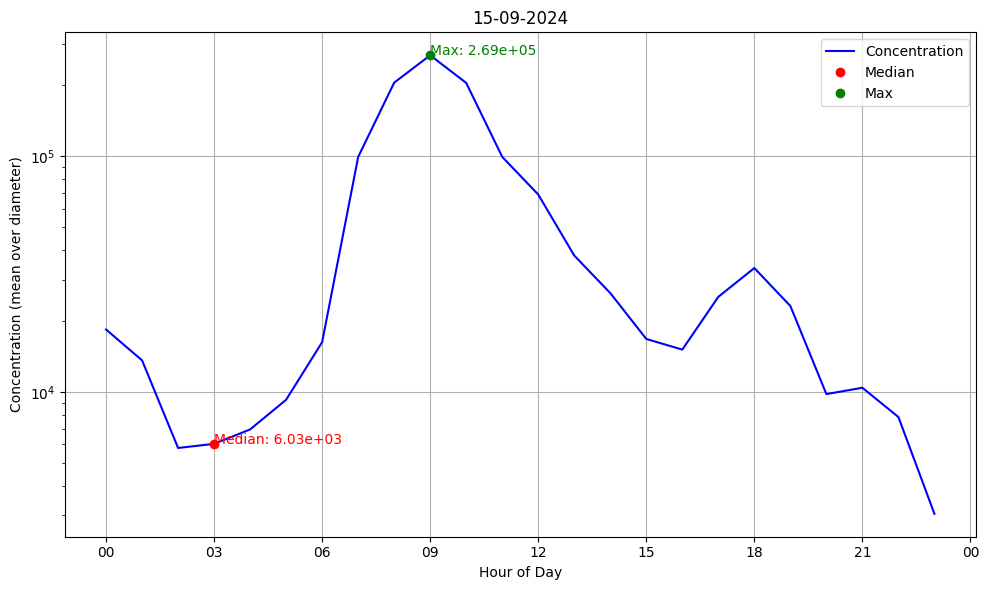

In [49]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Calculate the median and maximum values
median_value = background_daily_median.sel(date='2024-09-15')
max_value = active_daily_max.sel(date='2024-09-15')

# Find the index of the closest value to the median and max
median_index = np.abs(sep15 - median_value).argmin()
max_index = np.abs(sep15 - max_value).argmin()

# Get the times for the median and max values
median_time = sep15['time'].values[median_index]
max_time = sep15['time'].values[max_index]

plt.figure(figsize=(10, 6))
plt.plot(sep15['time'], sep15, label='Concentration', color='blue')
plt.title('15-09-2024')
plt.xlabel('Hour of Day')
plt.ylabel('Concentration (mean over diameter)')
plt.yscale('log')
plt.grid(True)

# Format the x-axis to show only hours
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H'))

# Highlight the median point
plt.plot(median_time, median_value, 'ro', label='Median')
plt.text(median_time, median_value, f'Median: {median_value:.2e}', color='red', ha='left')

# Highlight the max point
plt.plot(max_time, max_value, 'go', label='Max')
plt.text(max_time, max_value, f'Max: {max_value:.2e}', color='green', ha='left')

plt.legend()
plt.tight_layout()
plt.show()


In [54]:
#convert the date to datetime to make it easier to deal with
daily_change['date'] = pd.to_datetime(daily_change['date'])

In [64]:
daily_change

<xarray.DataArray (date: 166)>
array([            nan, 101248.08546159,   6278.91565381,             nan,
        37394.7990572 ,  44659.75297171,  21623.08981677,  82743.98906365,
         5569.98481213,  31276.49787789,  43127.00876632,  13404.38145862,
        19683.70031179,  58950.87658501, 140491.56142687, 182703.36813526,
        36135.32941653,  31034.64337018,  53016.75772521, 109297.47344494,
        46752.08555324,  18109.07234271,  35069.40019256,  15737.67091617,
        99691.22045288,             nan,  31503.02999573,   -831.36626915,
         6811.92994676,   2053.59968014,  19992.39141583,  71402.26164347,
       100478.34037462,  30283.46635135,  12927.40656648,   3750.18138484,
        26345.78442868,   9428.22533281,  32059.54346831,  73572.3685537 ,
        22854.15716615,  13128.46119761,  71825.01675705,   1370.14035754,
         3275.47345471,  24969.76744924, 156827.56593837,  33218.55094303,
        14041.93990257,  25186.12174306,   4608.03905292,  -1572.62583557,
        45709.21812432,  45189.289753  ,  49796.08855623,  58962.84395479,
        40156.79362748,  11532.04005973, 112322.23555045,  68422.99561765,
       136910.04813579,  72269.52665036,  76034.93347834,  53989.54979708,
        47762.54657728,   7705.00643517,  11996.73765105,  18873.28643848,
        69835.28833533,  81373.69765125,  39692.45857743,  16584.07338248,
        30794.29372879,   6743.40446057,  15262.2399242 ,  67451.79457416,
         8928.18932239,    345.95084427,   8383.70785115,  30736.21147815,
...
        13930.72116033,  25920.49774286,  14015.23151141,  14376.46049143,
        30470.08049286,  16251.63372912,  25546.75272971,   8437.4366078 ,
        11366.06587161,   9008.45337615,  11627.16679711,  15378.72200648,
        27950.61623042,   8841.88886062,  19466.88752675,  33579.44297072,
        30530.56732112,  24124.6059996 ,  10572.66345751,  26371.81719639,
        31950.53288578,  23031.46602122,  21207.19127322,  14043.22668924,
                   nan,  28425.21286191,  11123.78352249,  15913.91456835,
        19110.50615586,   4691.69709957,  21653.52234247,  57226.63671907,
       230744.74960713, 262485.17922718, 126713.9190046 ,  75082.911922  ,
        25913.27370463,  19372.83805303,  26614.52079813,   3497.33215   ,
         6472.62726359,   6374.95705437,  11888.24105508,  27228.83505144,
        17468.19122681,   8663.20537109,  28847.6245089 ,  98019.8372589 ,
        14322.24987484,  21354.67270063,  15144.51041548,  34640.15311876,
        18800.90927459,  12037.00072271,  11997.5105541 ,   6116.50976833,
        14236.14913421,  11908.99116062,  28248.66290231,   9408.07469935,
         6649.94580782,  30152.24308574,  13638.53766818,   5953.47952349,
         8304.24476393,   1217.06520982,  13008.35633432,   9702.0405497 ,
        18208.3258726 ,   6716.78394775,   2056.65768646,  93816.72202371,
        12135.75897162,  20341.79356367,  10744.99417455,   2219.27050494,
         4647.93323769,   7388.7655893 ])
Coordinates:
  * date     (date) datetime64[ns] 2024-05-17 2024-05-18 ... 2024-10-29

In [76]:
daily_change.dropna(dim='date', how='any')

<xarray.DataArray (date: 162)>
array([101248.08546159,   6278.91565381,  37394.7990572 ,  44659.75297171,
        21623.08981677,  82743.98906365,   5569.98481213,  31276.49787789,
        43127.00876632,  13404.38145862,  19683.70031179,  58950.87658501,
       140491.56142687, 182703.36813526,  36135.32941653,  31034.64337018,
        53016.75772521, 109297.47344494,  46752.08555324,  18109.07234271,
        35069.40019256,  15737.67091617,  99691.22045288,  31503.02999573,
         -831.36626915,   6811.92994676,   2053.59968014,  19992.39141583,
        71402.26164347, 100478.34037462,  30283.46635135,  12927.40656648,
         3750.18138484,  26345.78442868,   9428.22533281,  32059.54346831,
        73572.3685537 ,  22854.15716615,  13128.46119761,  71825.01675705,
         1370.14035754,   3275.47345471,  24969.76744924, 156827.56593837,
        33218.55094303,  14041.93990257,  25186.12174306,   4608.03905292,
        -1572.62583557,  45709.21812432,  45189.289753  ,  49796.08855623,
        58962.84395479,  40156.79362748,  11532.04005973, 112322.23555045,
        68422.99561765, 136910.04813579,  72269.52665036,  76034.93347834,
        53989.54979708,  47762.54657728,   7705.00643517,  11996.73765105,
        18873.28643848,  69835.28833533,  81373.69765125,  39692.45857743,
        16584.07338248,  30794.29372879,   6743.40446057,  15262.2399242 ,
        67451.79457416,   8928.18932239,    345.95084427,   8383.70785115,
        30736.21147815,  24837.60433832,  40711.94876043,  17080.31062064,
...
        24281.1655791 ,  13930.72116033,  25920.49774286,  14015.23151141,
        14376.46049143,  30470.08049286,  16251.63372912,  25546.75272971,
         8437.4366078 ,  11366.06587161,   9008.45337615,  11627.16679711,
        15378.72200648,  27950.61623042,   8841.88886062,  19466.88752675,
        33579.44297072,  30530.56732112,  24124.6059996 ,  10572.66345751,
        26371.81719639,  31950.53288578,  23031.46602122,  21207.19127322,
        14043.22668924,  28425.21286191,  11123.78352249,  15913.91456835,
        19110.50615586,   4691.69709957,  21653.52234247,  57226.63671907,
       230744.74960713, 262485.17922718, 126713.9190046 ,  75082.911922  ,
        25913.27370463,  19372.83805303,  26614.52079813,   3497.33215   ,
         6472.62726359,   6374.95705437,  11888.24105508,  27228.83505144,
        17468.19122681,   8663.20537109,  28847.6245089 ,  98019.8372589 ,
        14322.24987484,  21354.67270063,  15144.51041548,  34640.15311876,
        18800.90927459,  12037.00072271,  11997.5105541 ,   6116.50976833,
        14236.14913421,  11908.99116062,  28248.66290231,   9408.07469935,
         6649.94580782,  30152.24308574,  13638.53766818,   5953.47952349,
         8304.24476393,   1217.06520982,  13008.35633432,   9702.0405497 ,
        18208.3258726 ,   6716.78394775,   2056.65768646,  93816.72202371,
        12135.75897162,  20341.79356367,  10744.99417455,   2219.27050494,
         4647.93323769,   7388.7655893 ])
Coordinates:
  * date     (date) datetime64[ns] 2024-05-18 2024-05-19 ... 2024-10-29

In [66]:
import numpy as np

# Define the desired percentiles
percentiles = [25, 50, 75]

# Compute percentiles using numpy
# This formula however puts the nan values in the highest percentile
data_percentiles = np.nanpercentile(daily_change.values, percentiles, axis=0)

# Print the result
print(f"25th percentile: {data_percentiles[0]}")
print(f"50th percentile (median): {data_percentiles[1]}")
print(f"75th percentile: {data_percentiles[2]}")


25th percentile: 11407.559418641678
50th percentile (median): 20529.373528135366
75th percentile: 37176.13110759249


## Rank Analysis

In [77]:

daily_change = daily_change.dropna(dim='date', how='any')  # Drop all rows with NaN values

# Step 1: Calculate the 10% percentile intervals
percentiles = np.nanpercentile(daily_change, np.arange(10, 101, 10))  # 10% intervals from 10 to 100%

# Step 2: Use np.digitize to rank the daily_change based on these percentile intervals
# The 'rank' array will contain indices of which percentile bin each value falls into
rank = np.digitize(daily_change, percentiles)

# Step 3: Attach the rank as a new coordinate to the DataArray
data_with_rank = xr.DataArray(rank, dims="date", coords={"date": daily_change["date"]})

# Step 4: Group by the calculated rank (each group corresponds to a 10% interval)
grouped_data = daily_change.groupby(data_with_rank)

# Display the groups
for rank_value, group in grouped_data:
    print(f"Rank group {rank_value}:")
    print(group)

# Initialize an empty dictionary to store the groups
grouped_dict = {}

# Loop over the groups and store them in the dictionary
for rank_value, group in grouped_data:
    grouped_dict[f"rank_group_{rank_value}"] = group

# Now, you can access each group using the dictionary, for example:
rank_group_0 = grouped_dict["rank_group_0"]
rank_group_1 = grouped_dict["rank_group_1"]
rank_group_2 = grouped_dict["rank_group_2"]
rank_group_3 = grouped_dict["rank_group_3"]
rank_group_4 = grouped_dict["rank_group_4"]
rank_group_5 = grouped_dict["rank_group_5"]
rank_group_6 = grouped_dict["rank_group_6"]
rank_group_7 = grouped_dict["rank_group_7"]
rank_group_8 = grouped_dict["rank_group_8"]
rank_group_9 = grouped_dict["rank_group_9"]
rank_group_10 = grouped_dict["rank_group_10"]


Rank group 0:
<xarray.DataArray (date: 17)>
array([ 5569.98481213,  -831.36626915,  2053.59968014,  3750.18138484,
        1370.14035754,  3275.47345471,  4608.03905292, -1572.62583557,
         345.95084427,  4691.69709957,  3497.33215   ,  6116.50976833,
        5953.47952349,  1217.06520982,  2056.65768646,  2219.27050494,
        4647.93323769])
Coordinates:
  * date     (date) datetime64[ns] 2024-05-25 2024-06-13 ... 2024-10-28
Rank group 1:
<xarray.DataArray (date: 16)>
array([6278.91565381, 6811.92994676, 7705.00643517, 6743.40446057,
       8928.18932239, 8383.70785115, 7510.35667746, 8437.4366078 ,
       8841.88886062, 6472.62726359, 6374.95705437, 8663.20537109,
       6649.94580782, 8304.24476393, 6716.78394775, 7388.7655893 ])
Coordinates:
  * date     (date) datetime64[ns] 2024-05-19 2024-06-14 ... 2024-10-29
Rank group 2:
<xarray.DataArray (date: 16)>
array([ 9428.22533281, 11532.04005973, 11996.73765105, 11366.06587161,
        9008.45337615, 11627.16679711, 10572.66345

In [78]:
import numpy as np

# Dictionary to store the median values and dates for each rank group
medians_with_dates = {}

# Iterate through each rank group
for i in range(11):
    # Select the rank group
    rank_group = grouped_dict[f"rank_group_{i}"]

    # Calculate the median value
    median_value = np.nanmedian(rank_group)

    # Find the index of the value closest to the median
    median_index = np.abs(rank_group - median_value).argmin()

    # Get the date corresponding to the median value
    median_date = rank_group['date'].values[median_index]

    # Store both the median value and the date in the dictionary
    medians_with_dates[f"rank_group_{i}"] = {"median_value": median_value, "median_date": median_date}

# Print the results
for rank, data in medians_with_dates.items():
    print(f"{rank}: Median Value = {data['median_value']}, Median Date = {data['median_date']}")


rank_group_0: Median Value = 3275.4734547096195, Median Date = 2024-06-30T00:00:00.000000000
rank_group_1: Median Value = 7449.561133379691, Median Date = 2024-08-11T00:00:00.000000000
rank_group_2: Median Value = 11449.052965670957, Median Date = 2024-07-13T00:00:00.000000000
rank_group_3: Median Value = 14042.583295903452, Median Date = 2024-07-04T00:00:00.000000000
rank_group_4: Median Value = 18504.617573594336, Median Date = 2024-10-04T00:00:00.000000000
rank_group_5: Median Value = 24202.88578935046, Median Date = 2024-08-30T00:00:00.000000000
rank_group_6: Median Value = 30217.854718540657, Median Date = 2024-06-19T00:00:00.000000000
rank_group_7: Median Value = 36957.463157987964, Median Date = 2024-05-21T00:00:00.000000000
rank_group_8: Median Value = 63207.31926447625, Median Date = 2024-07-11T00:00:00.000000000
rank_group_9: Median Value = 105272.77945326226, Median Date = 2024-05-18T00:00:00.000000000
rank_group_10: Median Value = 262485.17922717996, Median Date = 2024-09-1

In [70]:
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.cm as cm

# Function to plot the ds with non-negative colorbars
def plot_spectral_data(var, title, ax):
    
    # Plot the contour
    c = ax.contourf(var['time'], var['diameter'], var.T,levels=np.arange(var.min(),var.max().item(),100),locator=ticker.LogLocator(), cmap=cm.YlGnBu)
    
    # Set up the colorbar
    cbar = plt.colorbar(c, ax=ax,ticks=[1,1e1,1e2,1e3,1e4,1e5,1e6])
    cbar.set_label('Concentration (cm$^-3$)')
    ax.set_yscale('log')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Diameter (m)')
    ax.set_title(title)

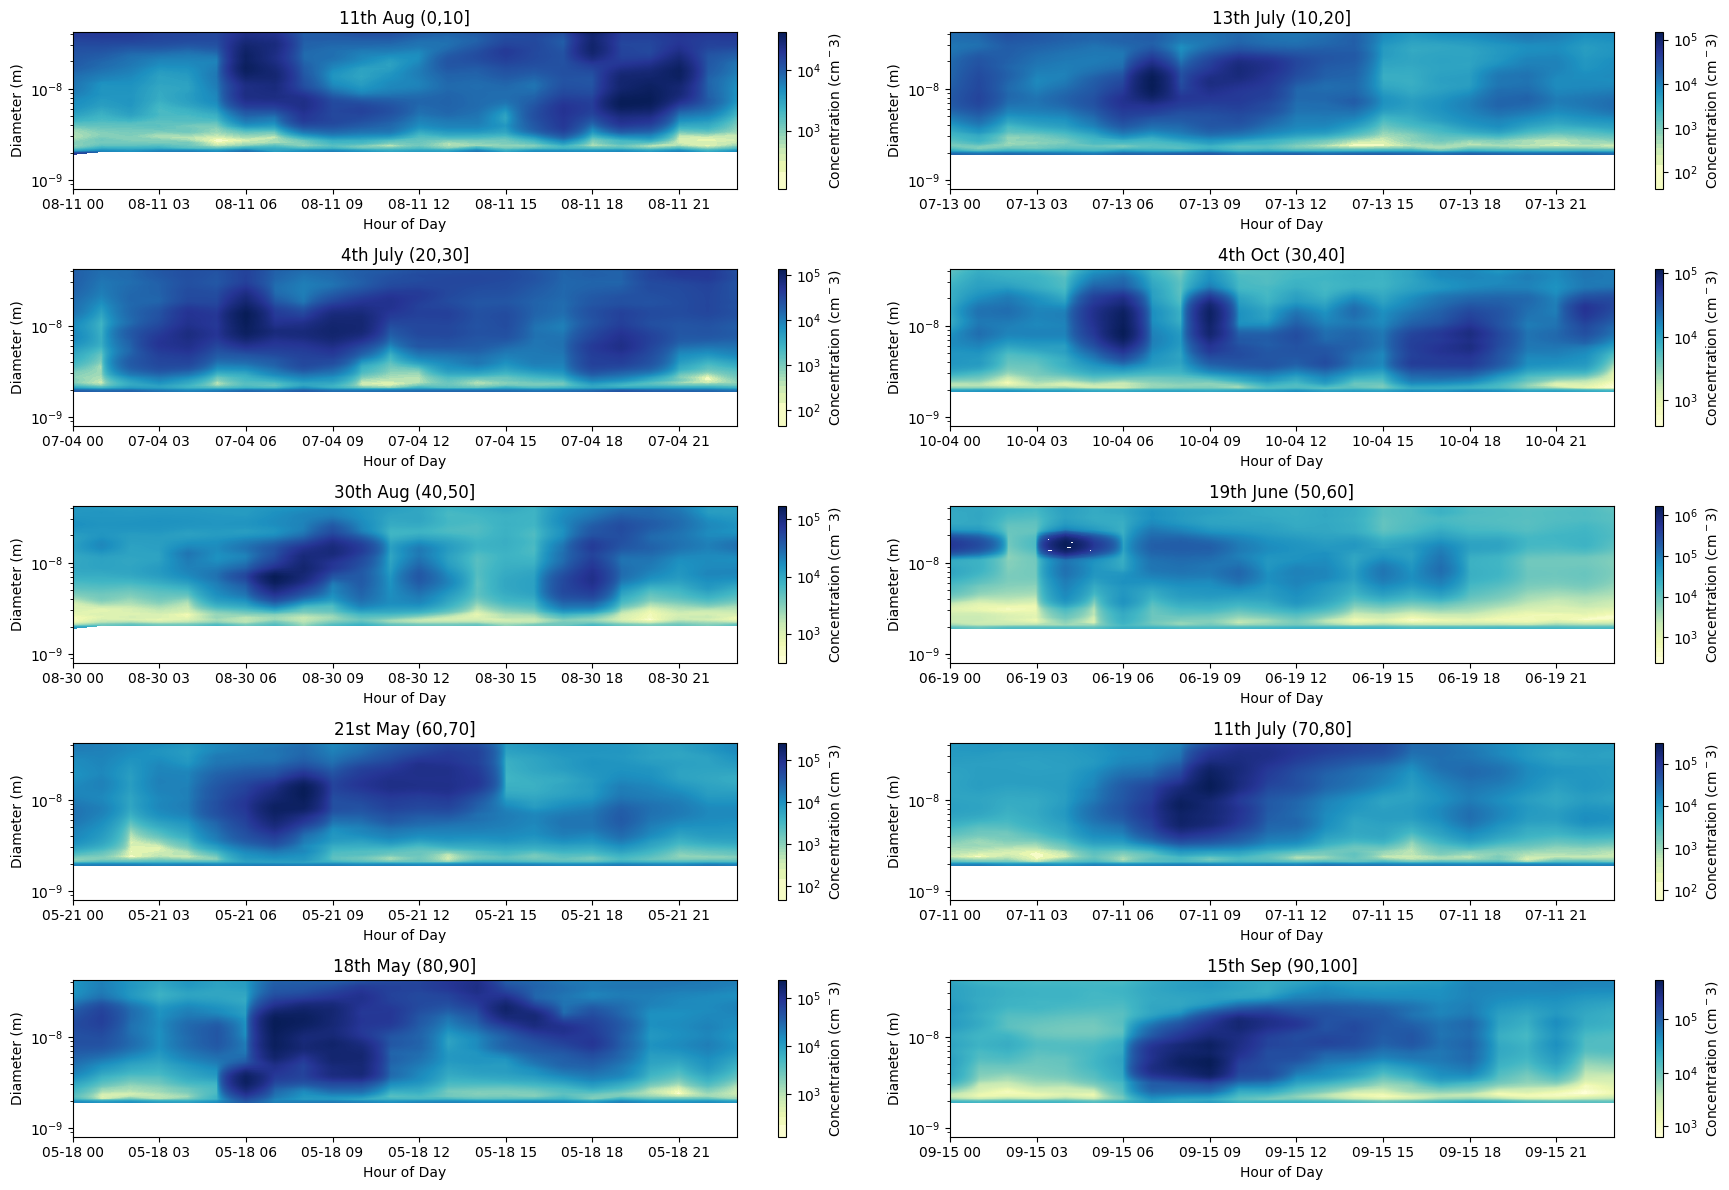

In [71]:
# Set up the plots
fig, axs = plt.subplots(5, 2, figsize=(18, 12))
axs = axs.ravel()

plot_spectral_data(particles.sel(time=slice('2024-08-11','2024-08-11')), '11th Aug (0,10]', axs[0])
plot_spectral_data(particles.sel(time=slice('2024-07-13','2024-07-13')), '13th July (10,20]', axs[1])
plot_spectral_data(particles.sel(time=slice('2024-07-04','2024-07-04')), '4th July (20,30]', axs[2])
plot_spectral_data(particles.sel(time=slice('2024-10-04','2024-10-04')), '4th Oct (30,40]', axs[3])
plot_spectral_data(particles.sel(time=slice('2024-08-30','2024-08-30')), '30th Aug (40,50]', axs[4])
plot_spectral_data(particles.sel(time=slice('2024-06-19','2024-06-19')), '19th June (50,60]', axs[5])
plot_spectral_data(particles.sel(time=slice('2024-05-21','2024-05-21')), '21st May (60,70]', axs[6])
plot_spectral_data(particles.sel(time=slice('2024-07-11','2024-07-11')), '11th July (70,80]', axs[7])
plot_spectral_data(particles.sel(time=slice('2024-05-18','2024-05-18')), '18th May (80,90]', axs[8])
plot_spectral_data(particles.sel(time=slice('2024-09-15','2024-09-15')), '15th Sep (90,100]', axs[9])

plt.tight_layout()
plt.show()

## Introduce complementary data

In [79]:
met1 = pd.read_csv('/home/coliewo/Desktop/DATA/CNR/merged_output.csv')
met2 = pd.read_csv('/home/coliewo/Desktop/DATA/CNR/merged_output2.csv')

# Concatenate along the time axis
complementary = pd.concat([met1, met2])

# Convert the 'datetime' column to a pandas datetime object for time series plotting
complementary['datetime'] = pd.to_datetime(complementary['datetime'])

# Set 'datetime' as the index for easy plotting of the time series
complementary.set_index('datetime', inplace=True)

In [82]:
import pandas as pd

# Dictionary to store filtered data for each rank group
filtered_data_by_rank = {}


# Iterate through each rank group (assuming rank groups are in a dictionary `grouped_dict`)
for i in range(11):  # Adjust if you have a different number of groups
    # Select the current rank group
    rank_group = grouped_dict[f"rank_group_{i}"]
    
    # Get the unique dates for this rank group (without hour)
    rank_dates = pd.to_datetime(rank_group.date.values).normalize()

    # Select all rows from the complementary DataFrame for each date in rank_dates
    # Using the index for filtering
    filtered_data = complementary[complementary.index.normalize().isin(rank_dates)]

    # Store the filtered data in the dictionary
    filtered_data_by_rank[f"rank_group_{i}"] = filtered_data

# Now, `filtered_data_by_rank` contains the complementary data divided into ranks with all hours included
for rank, data in filtered_data_by_rank.items():
    print(f"{rank}:\n{data}")


rank_group_0:
                            O3   NO[ppb]   NO2[ppb]   NOx[ppb]  \
datetime                                                         
2024-05-25 00:00:00  24.299333  0.586450   5.958683   6.545183   
2024-05-25 01:00:00  28.696833  0.503950   3.951200   4.455100   
2024-05-25 02:00:00  27.964500  0.472033   3.063500   3.535700   
2024-05-25 03:00:00  26.053500  0.509750   3.572667   4.082500   
2024-05-25 04:00:00  23.280333  0.916117   4.799250   5.715283   
...                        ...       ...        ...        ...   
2024-10-28 19:00:00   2.010863  8.084800  10.377833  18.462667   
2024-10-28 20:00:00   2.939122  2.698383   8.802917  11.501300   
2024-10-28 21:00:00   4.756367  0.226250   5.971783   6.198133   
2024-10-28 22:00:00   1.871385  2.431783   6.788633   9.220367   
2024-10-28 23:00:00   2.456733  0.700967   5.827567   6.528483   

                     Radiation_Value   T_air[C]     RH[%%]  Rain_acc[mm]  \
datetime                                           

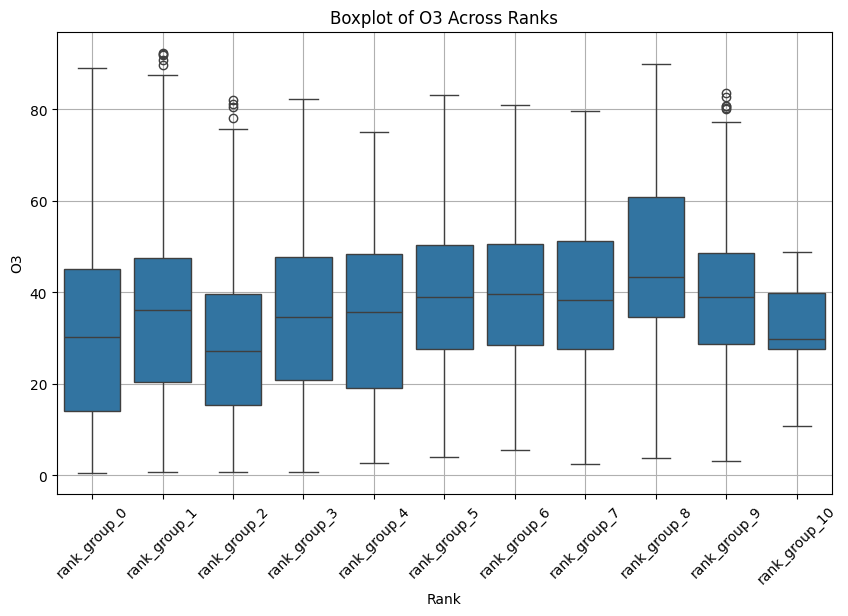

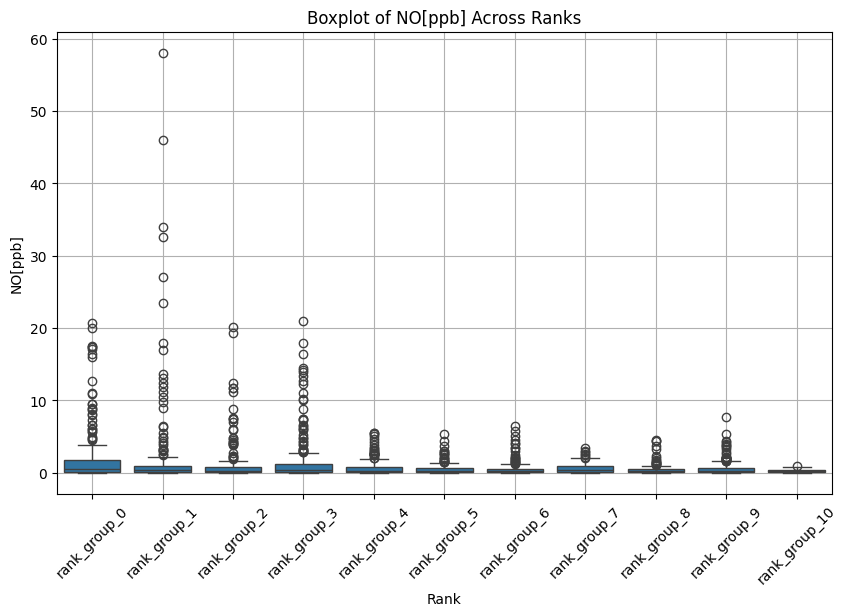

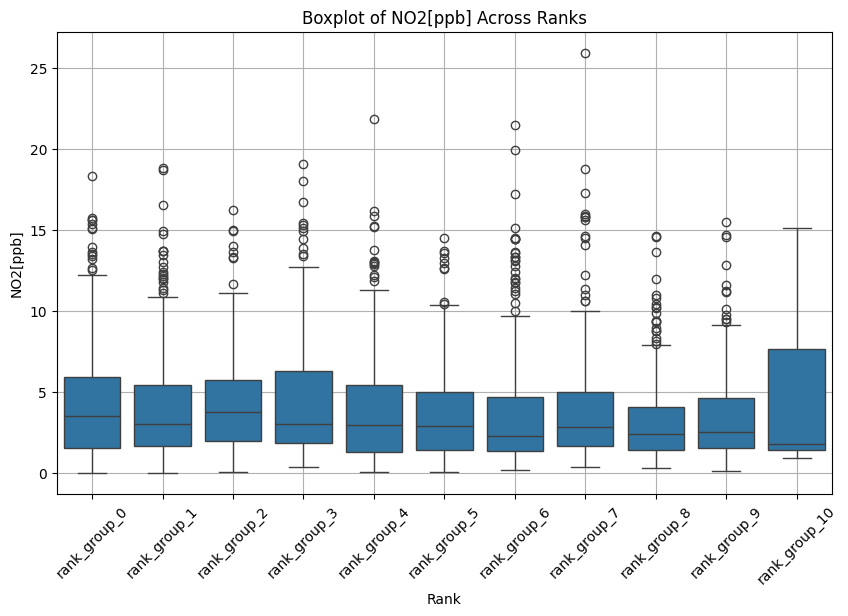

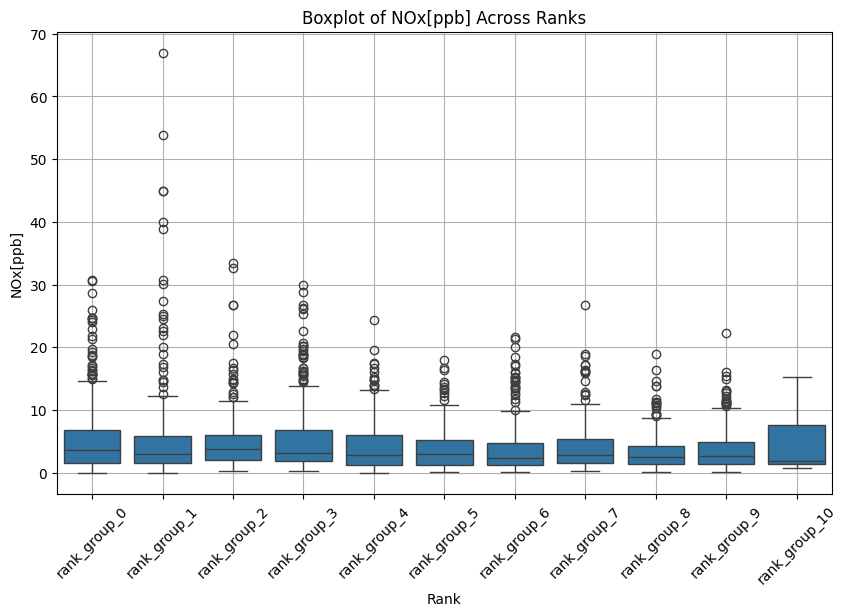

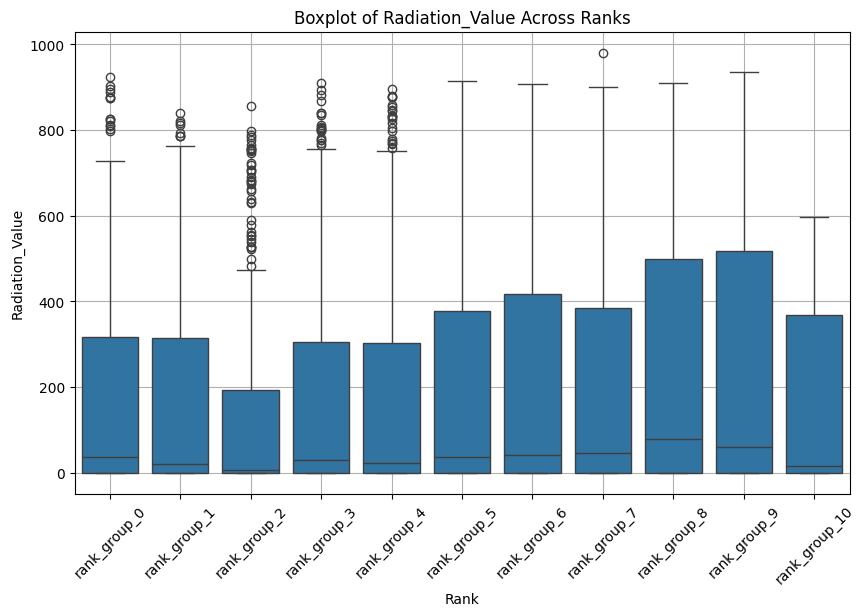

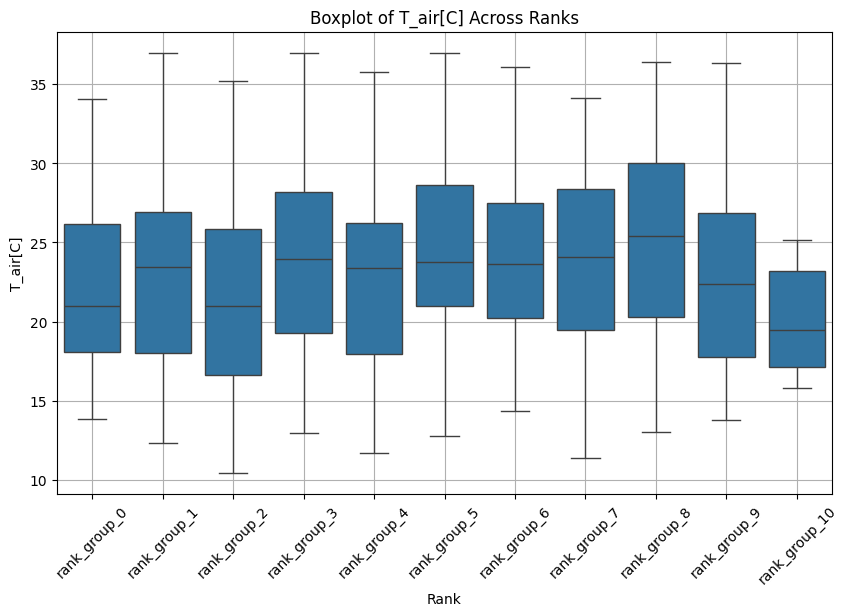

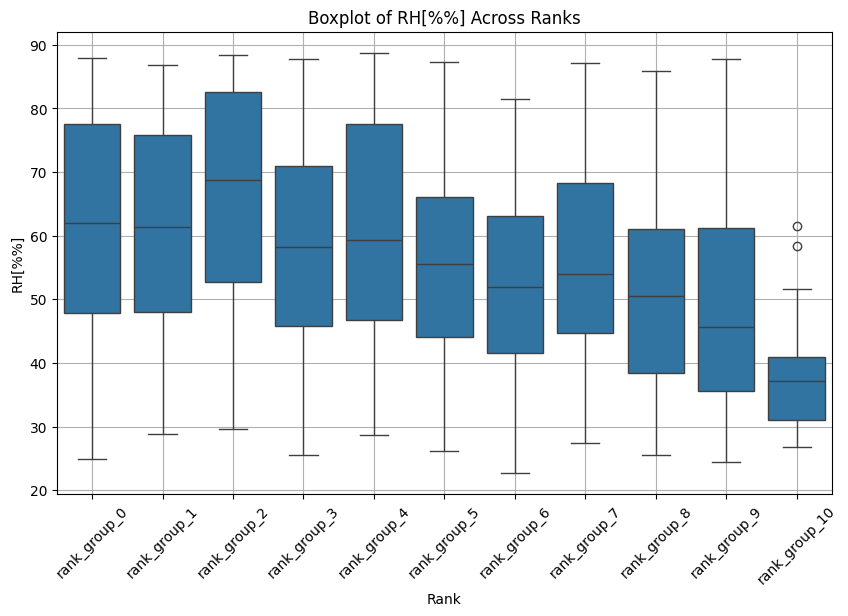

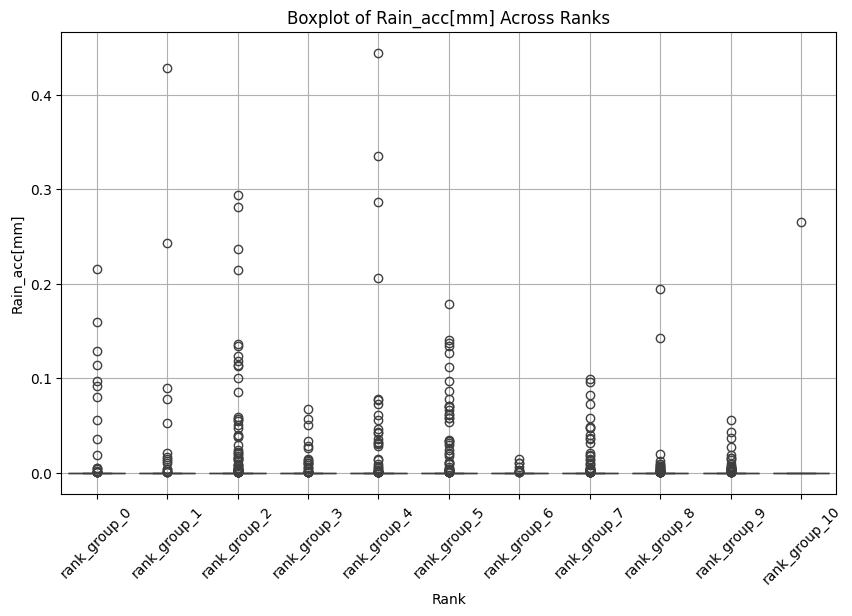

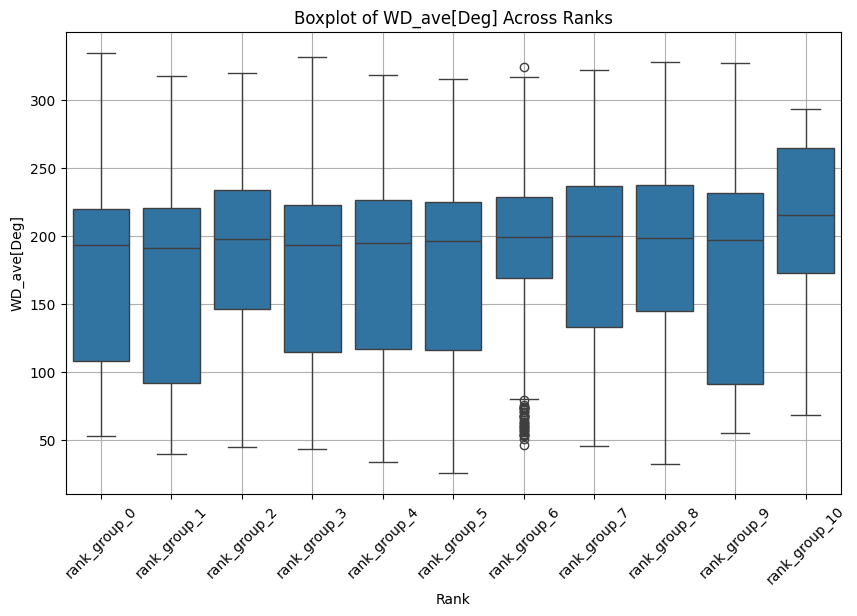

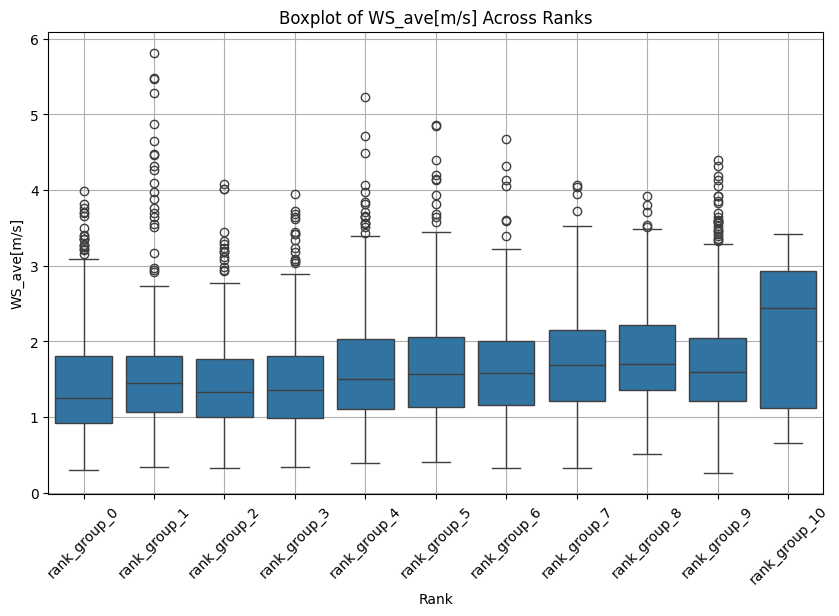

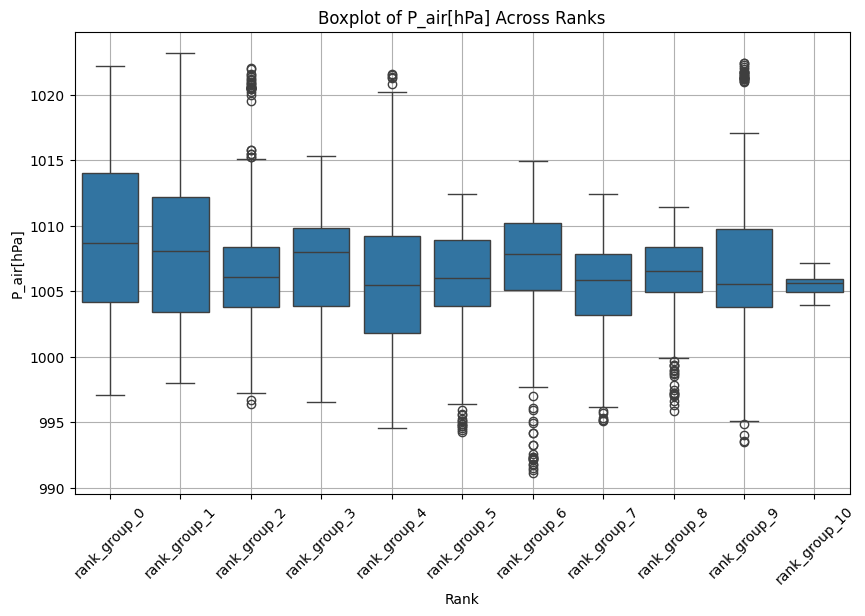

In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine data for each rank group into a single DataFrame for each variable
for variable in complementary.columns:  # Iterate over each variable in the dataset
    variable_data = []

    # Collect data for each rank and store it in a format for boxplot
    for rank, data in filtered_data_by_rank.items():
        rank_values = data[variable].dropna()  # Drop NaN values for each rank group
        rank_df = pd.DataFrame({variable: rank_values, 'Rank': rank})
        variable_data.append(rank_df)

    # Concatenate all rank data for this variable
    combined_data = pd.concat(variable_data)

    # Plot the boxplot for this variable across ranks
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=combined_data, x='Rank', y=variable)
    plt.title(f'Boxplot of {variable} Across Ranks')
    plt.xlabel('Rank')
    plt.ylabel(variable)
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()


### Black carbon

In [84]:
bc = pd.read_csv('/home/coliewo/Desktop/DATA/CNR/bc.csv')

# Convert the 'datetime' column to a pandas datetime object for time series plotting
bc['datetime'] = pd.to_datetime(bc['datetime'])

# Set 'datetime' as the index for easy plotting of the time series
bc.set_index('datetime', inplace=True)

In [86]:
# Dictionary to store filtered data for each rank group
bc_by_rank = {}

# Iterate through each rank group (assuming rank groups are in a dictionary `grouped_dict`)
for i in range(11):  # Adjust if you have a different number of groups
    # Select the current rank group
    rank_group = grouped_dict[f"rank_group_{i}"]
    
    # Get the unique dates for this rank group (without hour)
    rank_dates = pd.to_datetime(rank_group.date.values).normalize()

    # Select all rows from the Black carbob DataFrame for each date in rank_dates
    # Using the index for filtering
    filtered_data2 = bc[bc.index.normalize().isin(rank_dates)]

    # Store the filtered data in the dictionary
    bc_by_rank[f"rank_group_{i}"] = filtered_data2

# Now, `bc_by_rank` contains the bc data divided into ranks with all hours included
for rank, data in bc_by_rank.items():
    print(f"{rank}:\n{data}")


rank_group_0:
                      BC6[ng/m3]
datetime                        
2024-05-25 00:00:00     0.000000
2024-05-25 01:00:00     0.000000
2024-05-25 02:00:00     0.000000
2024-05-25 03:00:00     0.000000
2024-05-25 04:00:00     0.000000
...                          ...
2024-10-28 19:00:00  3299.283333
2024-10-28 20:00:00  2602.133333
2024-10-28 21:00:00  2148.566667
2024-10-28 22:00:00  2068.183333
2024-10-28 23:00:00  1918.966667

[408 rows x 1 columns]
rank_group_1:
                      BC6[ng/m3]
datetime                        
2024-05-19 00:00:00     0.000000
2024-05-19 01:00:00     0.000000
2024-05-19 02:00:00     0.000000
2024-05-19 03:00:00     0.000000
2024-05-19 04:00:00     0.000000
...                          ...
2024-10-29 19:00:00  4759.050000
2024-10-29 20:00:00  3665.400000
2024-10-29 21:00:00  3515.616667
2024-10-29 22:00:00  2537.033333
2024-10-29 23:00:00  2053.483333

[384 rows x 1 columns]
rank_group_2:
                      BC6[ng/m3]
datetime           

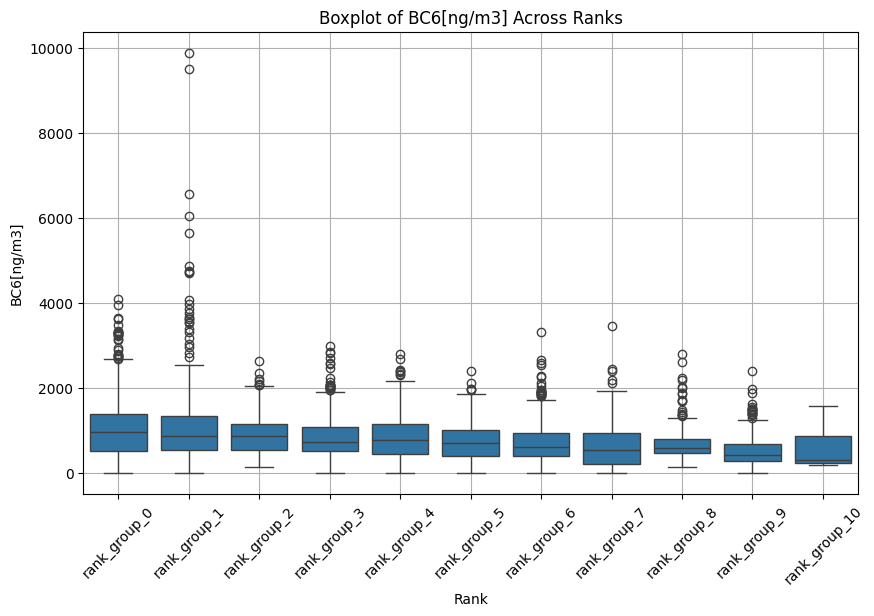

In [87]:
# Specify the variable you want to plot
variable = 'BC6[ng/m3]' 

# Collect data for each rank group
variable_data = []

for rank, data in bc_by_rank.items():
    rank_values = data[variable].dropna()  # Drop NaN values for this rank group
    rank_df = pd.DataFrame({variable: rank_values, 'Rank': rank})
    variable_data.append(rank_df)

# Concatenate all rank data for this variable
combined_data = pd.concat(variable_data)

# Plot the boxplot for this variable across ranks
plt.figure(figsize=(10, 6))
sns.boxplot(data=combined_data, x='Rank', y=variable)
plt.title(f'Boxplot of {variable} Across Ranks')
plt.xlabel('Rank')
plt.ylabel(variable)
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


## NPF Mode Fitting

In [88]:
daily_change

<xarray.DataArray (date: 162)>
array([101248.08546159,   6278.91565381,  37394.7990572 ,  44659.75297171,
        21623.08981677,  82743.98906365,   5569.98481213,  31276.49787789,
        43127.00876632,  13404.38145862,  19683.70031179,  58950.87658501,
       140491.56142687, 182703.36813526,  36135.32941653,  31034.64337018,
        53016.75772521, 109297.47344494,  46752.08555324,  18109.07234271,
        35069.40019256,  15737.67091617,  99691.22045288,  31503.02999573,
         -831.36626915,   6811.92994676,   2053.59968014,  19992.39141583,
        71402.26164347, 100478.34037462,  30283.46635135,  12927.40656648,
         3750.18138484,  26345.78442868,   9428.22533281,  32059.54346831,
        73572.3685537 ,  22854.15716615,  13128.46119761,  71825.01675705,
         1370.14035754,   3275.47345471,  24969.76744924, 156827.56593837,
        33218.55094303,  14041.93990257,  25186.12174306,   4608.03905292,
        -1572.62583557,  45709.21812432,  45189.289753  ,  49796.08855623,
        58962.84395479,  40156.79362748,  11532.04005973, 112322.23555045,
        68422.99561765, 136910.04813579,  72269.52665036,  76034.93347834,
        53989.54979708,  47762.54657728,   7705.00643517,  11996.73765105,
        18873.28643848,  69835.28833533,  81373.69765125,  39692.45857743,
        16584.07338248,  30794.29372879,   6743.40446057,  15262.2399242 ,
        67451.79457416,   8928.18932239,    345.95084427,   8383.70785115,
        30736.21147815,  24837.60433832,  40711.94876043,  17080.31062064,
...
        24281.1655791 ,  13930.72116033,  25920.49774286,  14015.23151141,
        14376.46049143,  30470.08049286,  16251.63372912,  25546.75272971,
         8437.4366078 ,  11366.06587161,   9008.45337615,  11627.16679711,
        15378.72200648,  27950.61623042,   8841.88886062,  19466.88752675,
        33579.44297072,  30530.56732112,  24124.6059996 ,  10572.66345751,
        26371.81719639,  31950.53288578,  23031.46602122,  21207.19127322,
        14043.22668924,  28425.21286191,  11123.78352249,  15913.91456835,
        19110.50615586,   4691.69709957,  21653.52234247,  57226.63671907,
       230744.74960713, 262485.17922718, 126713.9190046 ,  75082.911922  ,
        25913.27370463,  19372.83805303,  26614.52079813,   3497.33215   ,
         6472.62726359,   6374.95705437,  11888.24105508,  27228.83505144,
        17468.19122681,   8663.20537109,  28847.6245089 ,  98019.8372589 ,
        14322.24987484,  21354.67270063,  15144.51041548,  34640.15311876,
        18800.90927459,  12037.00072271,  11997.5105541 ,   6116.50976833,
        14236.14913421,  11908.99116062,  28248.66290231,   9408.07469935,
         6649.94580782,  30152.24308574,  13638.53766818,   5953.47952349,
         8304.24476393,   1217.06520982,  13008.35633432,   9702.0405497 ,
        18208.3258726 ,   6716.78394775,   2056.65768646,  93816.72202371,
        12135.75897162,  20341.79356367,  10744.99417455,   2219.27050494,
         4647.93323769,   7388.7655893 ])
Coordinates:
  * date     (date) datetime64[ns] 2024-05-18 2024-05-19 ... 2024-10-29

/home/coliewo/.local/lib/python3.10/site-packages/xarray/core/computation.py:822: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


(array([0.02827349, 0.        , 0.        , 0.        , 0.        ,
        0.02827349, 0.02827349, 0.        , 0.08482048, 0.        ,
        0.08482048, 0.08482048, 0.08482048, 0.25446144, 0.28273493,
        0.19791445, 0.53719637, 0.31100842, 0.42410239, 0.42410239,
        0.45237589, 0.22618794, 0.19791445, 0.14136746, 0.25446144,
        0.14136746, 0.08482048, 0.08482048, 0.02827349, 0.05654699]),
 array([ 5.8462967 ,  6.0673518 ,  6.28840691,  6.50946202,  6.73051712,
         6.95157223,  7.17262734,  7.39368244,  7.61473755,  7.83579266,
         8.05684776,  8.27790287,  8.49895798,  8.72001308,  8.94106819,
         9.1621233 ,  9.3831784 ,  9.60423351,  9.82528862, 10.04634372,
        10.26739883, 10.48845394, 10.70950905, 10.93056415, 11.15161926,
        11.37267437, 11.59372947, 11.81478458, 12.03583969, 12.25689479,
        12.4779499 ]),
 <BarContainer object of 30 artists>)

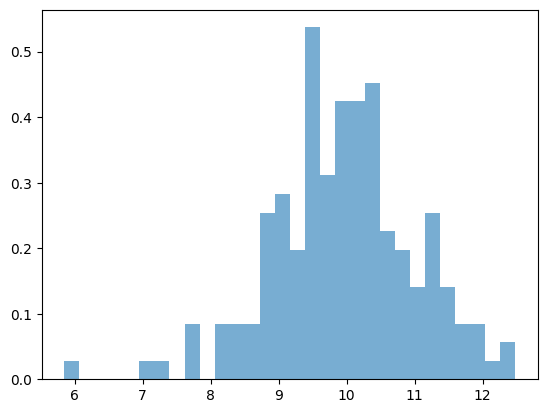

In [94]:
log_dist = np.log(daily_change).dropna(dim='date')
plt.hist(log_dist, bins=30, density=True, alpha=0.6)

In [95]:
log_dist.values.flatten()

array([11.52532908,  8.74495258, 10.52928691, 10.70682799,  9.981517  ,
       11.32350665,  8.62514761, 10.35062223, 10.67190473,  9.50333691,
        9.88754618, 10.98445978, 11.8529027 , 12.11561918, 10.49502632,
       10.34285939, 10.87836333, 11.60182856, 10.75261414,  9.80416833,
       10.46508424,  9.66381254, 11.50983289, 10.35783901,  8.82643076,
        7.62734947,  9.90310705, 11.17608482, 11.51769746, 10.31835718,
        9.46710488,  8.22955949, 10.17906356,  9.15146316, 10.37535019,
       11.20602481, 10.03688831,  9.48253776, 11.18198812,  7.22266846,
        8.0942177 , 10.12542107, 11.96290217, 10.41086376,  9.54980384,
       10.1340484 ,  8.43555768, 10.73005527, 10.71861539, 10.81569172,
       10.98466276, 10.60054691,  9.35288453, 11.62912712, 11.13346424,
       11.82707941, 11.18815783, 11.23894816, 10.89654578, 10.77399707,
        8.94962558,  9.39239003,  9.84550279, 11.15389472, 11.30680738,
       10.58891649,  9.71619808, 10.33508468,  8.81632019,  9.63

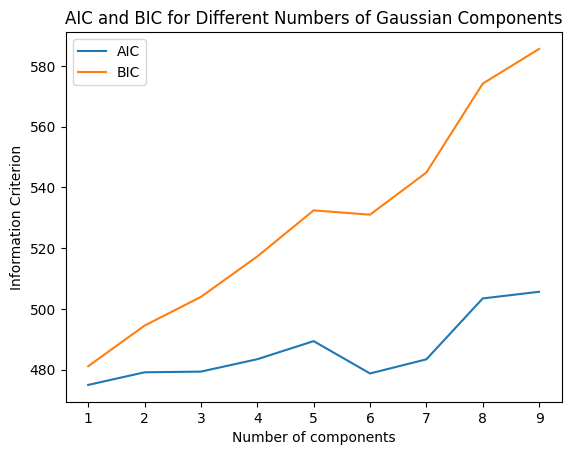

In [96]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Reshape log_dist2 for the Gaussian Mixture model (it expects a 2D array)
log_dist2 = log_dist.values.flatten().reshape(-1, 1)

# Test various numbers of components
n_components = np.arange(1, 10)  # Adjust the range based on your expectation
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(log_dist2) for n in n_components]

# Calculate the AIC and BIC
aics = [m.aic(log_dist2) for m in models]
bics = [m.bic(log_dist2) for m in models]

# Plot the results
plt.plot(n_components, aics, label='AIC')
plt.plot(n_components, bics, label='BIC')
plt.legend(loc='best')
plt.xlabel('Number of components')
plt.ylabel('Information Criterion')
plt.title('AIC and BIC for Different Numbers of Gaussian Components')
plt.show()

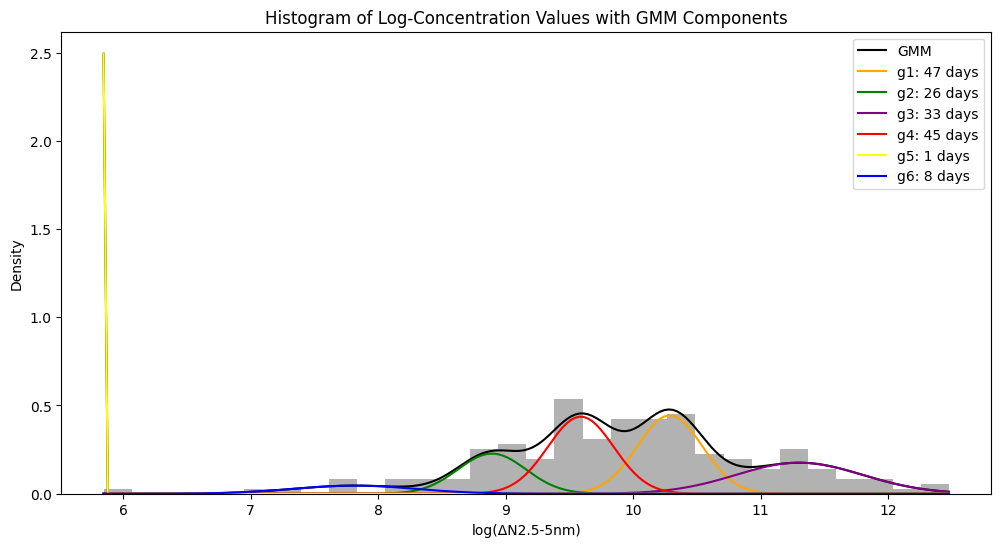

Number of data points in g1: 47
Number of data points in g2: 26
Number of data points in g3: 33
Number of data points in g4: 45
Number of data points in g5: 1
Number of data points in g6: 8


In [97]:
# Fit Gaussian distributions to the data

# Fit a Gaussian Mixture Model with 6 components
gmm = GaussianMixture(n_components=6, random_state=0)
gmm.fit(log_dist2)

# Predict the component for each data point
gmm_labels = gmm.predict(log_dist2)

# Count the number of data points in each component
unique, counts = np.unique(gmm_labels, return_counts=True)
component_frequencies = dict(zip(unique, counts))

# Plot the histogram and Gaussian Mixture Model fits
plt.figure(figsize=(12, 6))
plt.hist(log_dist2, bins=30, density=True, alpha=0.6, color='gray')

# Plot the GMM components
xs = np.linspace(min(log_dist2), max(log_dist2), 200).reshape(-1, 1)
logprob = gmm.score_samples(xs)
responsibilities = gmm.predict_proba(xs)
pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.plot(xs, pdf, label='GMM', color='black')
colors = ['orange', 'green', 'purple', 'red', 'yellow', 'blue']
for i in range(6):
    plt.plot(xs, pdf_individual[:, i], label=f'g{i+1}: {component_frequencies.get(i, 0)} days', color=colors[i])

plt.xlabel('log(ΔN2.5-5nm)')
plt.ylabel('Density')
plt.title('Histogram of Log-Concentration Values with GMM Components')
plt.legend()

# Show the plot
plt.show()

# Print the number of data points assigned to each GMM component
print(f'Number of data points in g1: {component_frequencies.get(0, 0)}')
print(f'Number of data points in g2: {component_frequencies.get(1, 0)}')
print(f'Number of data points in g3: {component_frequencies.get(2, 0)}')
print(f'Number of data points in g4: {component_frequencies.get(3, 0)}')
print(f'Number of data points in g5: {component_frequencies.get(4, 0)}')
print(f'Number of data points in g6: {component_frequencies.get(5, 0)}')

In [101]:
# Fit GMM and predict components
gmm = GaussianMixture(n_components=6, random_state=0)
components = gmm.fit_predict(log_dist.values.reshape(-1, 1))

# Attempting to add components as a coordinate
log_dist.coords['component'] = ('date', components)  # Make sure dimensions match

In [103]:
# Select log_dist where component is 0,1 - 5
selected_data_where_component_0 = log_dist.where(log_dist.component == 0, drop=True)
selected_data_where_component_1 = log_dist.where(log_dist.component == 1, drop=True)
selected_data_where_component_2 = log_dist.where(log_dist.component == 2, drop=True)
selected_data_where_component_3 = log_dist.where(log_dist.component == 3, drop=True)
selected_data_where_component_4 = log_dist.where(log_dist.component == 4, drop=True)
selected_data_where_component_5 = log_dist.where(log_dist.component == 5, drop=True)


In [105]:
selected_data_where_component_0.date

<xarray.DataArray 'date' (date: 47)>
array(['2024-05-21T00:00:00.000000000', '2024-05-22T00:00:00.000000000',
       '2024-05-23T00:00:00.000000000', '2024-05-26T00:00:00.000000000',
       '2024-05-27T00:00:00.000000000', '2024-06-02T00:00:00.000000000',
       '2024-06-03T00:00:00.000000000', '2024-06-08T00:00:00.000000000',
       '2024-06-12T00:00:00.000000000', '2024-06-19T00:00:00.000000000',
       '2024-06-22T00:00:00.000000000', '2024-06-24T00:00:00.000000000',
       '2024-06-26T00:00:00.000000000', '2024-07-01T00:00:00.000000000',
       '2024-07-03T00:00:00.000000000', '2024-07-05T00:00:00.000000000',
       '2024-07-08T00:00:00.000000000', '2024-07-09T00:00:00.000000000',
       '2024-07-12T00:00:00.000000000', '2024-07-26T00:00:00.000000000',
       '2024-07-28T00:00:00.000000000', '2024-08-04T00:00:00.000000000',
       '2024-08-05T00:00:00.000000000', '2024-08-06T00:00:00.000000000',
       '2024-08-08T00:00:00.000000000', '2024-08-12T00:00:00.000000000',
       '2024-08-14T00:00:00.000000000', '2024-08-17T00:00:00.000000000',
       '2024-08-19T00:00:00.000000000', '2024-08-25T00:00:00.000000000',
       '2024-08-28T00:00:00.000000000', '2024-08-29T00:00:00.000000000',
       '2024-08-30T00:00:00.000000000', '2024-09-01T00:00:00.000000000',
       '2024-09-02T00:00:00.000000000', '2024-09-03T00:00:00.000000000',
       '2024-09-04T00:00:00.000000000', '2024-09-07T00:00:00.000000000',
       '2024-09-12T00:00:00.000000000', '2024-09-18T00:00:00.000000000',
       '2024-09-20T00:00:00.000000000', '2024-09-25T00:00:00.000000000',
       '2024-09-28T00:00:00.000000000', '2024-10-01T00:00:00.000000000',
       '2024-10-03T00:00:00.000000000', '2024-10-10T00:00:00.000000000',
       '2024-10-13T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * date       (date) datetime64[ns] 2024-05-21 2024-05-22 ... 2024-10-13
    component  (date) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0

### Take the days from the daily change data instead, then when plotting spectral plot, infer from particles data

In [131]:
# Select the dates from the daily_change data that are in each component.
g1_days = daily_change[daily_change['date'].dt.date.isin(selected_data_where_component_0.date.dt.date)]
g2_days = daily_change[daily_change['date'].dt.date.isin(selected_data_where_component_1.date.dt.date)]
g3_days = daily_change[daily_change['date'].dt.date.isin(selected_data_where_component_2.date.dt.date)]
g4_days = daily_change[daily_change['date'].dt.date.isin(selected_data_where_component_3.date.dt.date)]
g5_days = daily_change[daily_change['date'].dt.date.isin(selected_data_where_component_4.date.dt.date)]
g6_days = daily_change[daily_change['date'].dt.date.isin(selected_data_where_component_5.date.dt.date)]

### Find the dates for the median change

In [137]:
g1_days['date'].values[np.abs(g1_days - g1_days.median()).argmin()]

numpy.datetime64('2024-06-19T00:00:00.000000000')

In [138]:
g2_days['date'].values[np.abs(g2_days - g2_days.median()).argmin()]

numpy.datetime64('2024-06-14T00:00:00.000000000')

In [139]:
g3_days['date'].values[np.abs(g3_days - g3_days.median()).argmin()]

numpy.datetime64('2024-07-18T00:00:00.000000000')

In [140]:
g4_days['date'].values[np.abs(g4_days - g4_days.median()).argmin()]

numpy.datetime64('2024-09-30T00:00:00.000000000')

In [141]:
g5_days['date'].values[np.abs(g5_days - g5_days.median()).argmin()]

numpy.datetime64('2024-08-02T00:00:00.000000000')

In [142]:
g6_days['date'].values[np.abs(g6_days - g6_days.median()).argmin()]

numpy.datetime64('2024-10-22T00:00:00.000000000')

In [150]:
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.cm as cm

# Function to plot the ds with non-negative colorbars
def plot_spectral_data(var, title, ax):
    
    # Plot the contour
    c = ax.contourf(var['time'], var['diameter'], var.T,levels=np.arange(var.min(),var.max().item(),100),locator=ticker.LogLocator(), cmap=cm.YlGnBu)
    
    # Set up the colorbar
    cbar = plt.colorbar(c, ax=ax,ticks=[1,1e1,1e2,1e3,1e4,1e5,1e6])
    cbar.set_label('Concentration (cm$^-3$)')
    ax.set_yscale('log')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Diameter (m)')
    ax.set_title(title)

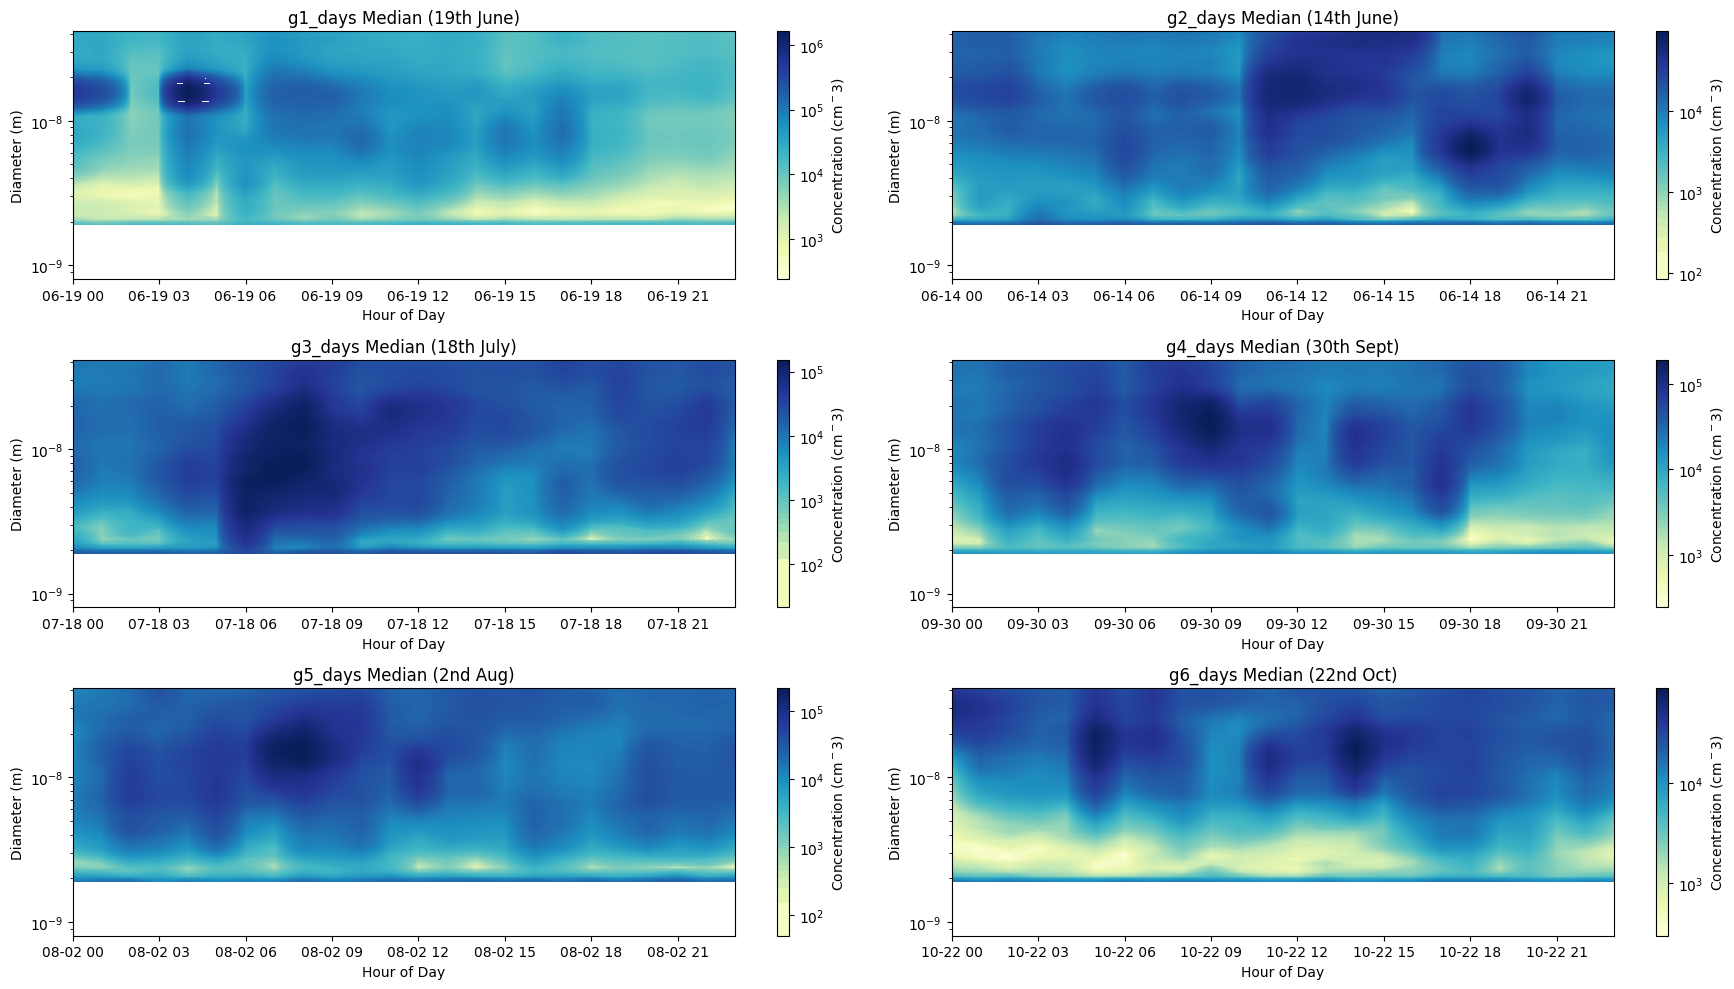

In [152]:
# Set up the plots
fig, axs = plt.subplots(3, 2, figsize=(18, 10))
axs = axs.ravel()

plot_spectral_data(particles.sel(time=slice('2024-06-19','2024-06-19')), 'g1_days Median (19th June)', axs[0])
plot_spectral_data(particles.sel(time=slice('2024-06-14','2024-06-14')), 'g2_days Median (14th June)', axs[1])
plot_spectral_data(particles.sel(time=slice('2024-07-18','2024-07-18')), 'g3_days Median (18th July)', axs[2])
plot_spectral_data(particles.sel(time=slice('2024-09-30','2024-09-30')), 'g4_days Median (30th Sept)', axs[3])
plot_spectral_data(particles.sel(time=slice('2024-08-02','2024-08-02')), 'g5_days Median (2nd Aug)', axs[4])
plot_spectral_data(particles.sel(time=slice('2024-10-22','2024-10-22')), 'g6_days Median (22nd Oct)', axs[5])

plt.tight_layout()
plt.show()

### Plot diurnal variation for each group instead...
From the data of 2.5-5nm

In [160]:
sub_5nm_mean

<xarray.DataArray (time: 3986)>
array([          nan,           nan,           nan, ..., 2099.55637118,
       2008.48862763,  923.29729843])
Coordinates:
  * time     (time) datetime64[ns] 2024-05-17 2024-05-17T01:00:00 ... 2024-10-30

In [161]:
# Select the dates from the sub_5nm_mean data that are in each component.
grp1_days = sub_5nm_mean[sub_5nm_mean['time'].dt.date.isin(selected_data_where_component_0.date.dt.date)]
grp2_days = sub_5nm_mean[sub_5nm_mean['time'].dt.date.isin(selected_data_where_component_1.date.dt.date)]
grp3_days = sub_5nm_mean[sub_5nm_mean['time'].dt.date.isin(selected_data_where_component_2.date.dt.date)]
grp4_days = sub_5nm_mean[sub_5nm_mean['time'].dt.date.isin(selected_data_where_component_3.date.dt.date)]
grp5_days = sub_5nm_mean[sub_5nm_mean['time'].dt.date.isin(selected_data_where_component_4.date.dt.date)]
grp6_days = sub_5nm_mean[sub_5nm_mean['time'].dt.date.isin(selected_data_where_component_5.date.dt.date)]

In [164]:
# Step 3: Now, calculate diurnal variations, e.g., the mean across each hour for each month
grp1_diurnal_variation = grp1_days.groupby(grp1_days.time.dt.hour).mean(dim='time')
grp2_diurnal_variation = grp2_days.groupby(grp2_days.time.dt.hour).mean(dim='time')
grp3_diurnal_variation = grp3_days.groupby(grp3_days.time.dt.hour).mean(dim='time')
grp4_diurnal_variation = grp4_days.groupby(grp4_days.time.dt.hour).mean(dim='time')
grp5_diurnal_variation = grp5_days.groupby(grp5_days.time.dt.hour).mean(dim='time')
grp6_diurnal_variation = grp6_days.groupby(grp6_days.time.dt.hour).mean(dim='time')

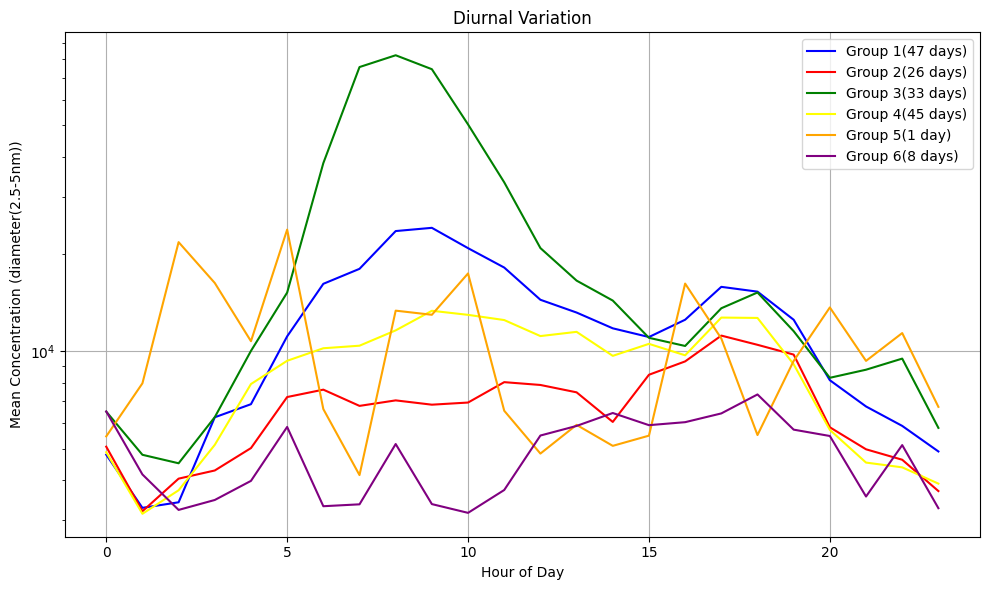

In [165]:
plt.figure(figsize=(10, 6))
plt.plot(grp1_diurnal_variation['hour'], grp1_diurnal_variation, label='Group 1(47 days)', color='blue')
plt.plot(grp2_diurnal_variation['hour'], grp2_diurnal_variation, label='Group 2(26 days)', color='red')
plt.plot(grp3_diurnal_variation['hour'], grp3_diurnal_variation, label='Group 3(33 days)', color='green')
plt.plot(grp4_diurnal_variation['hour'], grp4_diurnal_variation, label='Group 4(45 days)', color='yellow')
plt.plot(grp5_diurnal_variation['hour'], grp5_diurnal_variation, label='Group 5(1 day)', color='orange')
plt.plot(grp6_diurnal_variation['hour'], grp6_diurnal_variation, label='Group 6(8 days)', color='purple')

# Customize the plot 
plt.title('Diurnal Variation')
plt.xlabel('Hour of Day')
plt.ylabel('Mean Concentration (diameter(2.5-5nm))')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Try see the variation for the complementary data
How to divide the data, the groups are not in order

In [255]:
import pandas as pd

# Dates for each curve
group1_dates = pd.to_datetime(g3_days.date)  # highest curve
group2_dates = pd.to_datetime(g1_days.date)   # curve 2
group3_dates = pd.to_datetime(g4_days.date)  #curve 3
group4_dates = pd.to_datetime(g2_days.date)   #curve 4
group5_dates = pd.to_datetime(g6_days.date)   #curve 5
group6_dates = pd.to_datetime(g5_days.date)  #curve 6

# Create a new DataFrame to include group labels
comp_with_groups = complementary.copy()  # Keep the original untouched
comp_with_groups['Group'] = {}  # Initialize a 'Group' column

In [256]:
# Normalize index 
df_dates = complementary.index.normalize() # Reduce index to date part

# Rebuild mask
mask1 = df_dates.isin(group1_dates)
mask2 = df_dates.isin(group2_dates)
mask3 = df_dates.isin(group3_dates)
mask4 = df_dates.isin(group4_dates)
mask5 = df_dates.isin(group5_dates)
mask6 = df_dates.isin(group6_dates)


# Assign group labels
comp_with_groups.loc[mask1, 'Group'] = 'Group 1'
comp_with_groups.loc[mask2, 'Group'] = 'Group 2'
comp_with_groups.loc[mask3, 'Group'] = 'Group 3'
comp_with_groups.loc[mask4, 'Group'] = 'Group 4'
comp_with_groups.loc[mask5, 'Group'] = 'Group 5'
comp_with_groups.loc[mask6, 'Group'] = 'Group 6'

# Drop rows without a group (optional, if there are unmatched rows)
comp_with_groups = comp_with_groups.dropna(subset=['Group'])
comp_with_groups


O3    NO[ppb]   NO2[ppb]   NOx[ppb]  \
datetime                                                          
2024-05-18 00:00:00  23.030333   0.475850   8.553933   9.029850   
2024-05-18 01:00:00  22.023667   0.545483   7.341033   7.886467   
2024-05-18 02:00:00  28.566333   0.490817   4.364433   4.855283   
2024-05-18 03:00:00  28.848500   0.378450   2.926467   3.304850   
2024-05-18 04:00:00  21.463667   1.607183   5.730233   7.337383   
...                        ...        ...        ...        ...   
2024-10-29 19:00:00   0.812300  16.995067  13.678050  30.673283   
2024-10-29 20:00:00   2.274348   4.866417  11.128383  15.994817   
2024-10-29 21:00:00   4.929400   0.970800   8.362117   9.333050   
2024-10-29 22:00:00   5.381717   0.385117   7.030700   7.415800   
2024-10-29 23:00:00   4.751367   0.384717   6.541183   6.925883   

                     Radiation_Value   T_air[C]     RH[%%]  Rain_acc[mm]  \
datetime                                                                   
2024-05-18 00:00:00              NaN  15.625000  56.198333           0.0   
2024-05-18 01:00:00              NaN  14.416667  61.880000           0.0   
2024-05-18 02:00:00              NaN  14.741667  60.885000           0.0   
2024-05-18 03:00:00              NaN  14.400000  61.951667           0.0   
2024-05-18 04:00:00              NaN  13.755000  65.453333           0.0   
...                              ...        ...        ...           ...   
2024-10-29 19:00:00              0.0  16.271667  81.775000           0.0   
2024-10-29 20:00:00              0.0  15.796667  82.545000           0.0   
2024-10-29 21:00:00              0.0  15.453333  82.710000           0.0   
2024-10-29 22:00:00              0.0  15.200000  82.795000           0.0   
2024-10-29 23:00:00              0.0  14.878333  82.666667           0.0   

                     WD_ave[Deg]  WS_ave[m/s]   P_air[hPa]    Group  
datetime                                                             
2024-05-18 00:00:00   260.453333     0.845000  1005.966667  Group 1  
2024-05-18 01:00:00   236.193333     0.761667  1006.205000  Group 1  
2024-05-18 02:00:00   188.638333     1.701667  1006.561667  Group 1  
2024-05-18 03:00:00   209.328333     1.493333  1006.653333  Group 1  
2024-05-18 04:00:00   206.698333     1.570000  1007.048333  Group 1  
...                          ...          ...          ...      ...  
2024-10-29 19:00:00   202.880000     1.741667  1018.233333  Group 4  
2024-10-29 20:00:00   197.340000     1.715000  1018.273333  Group 4  
2024-10-29 21:00:00   201.998333     1.855000  1018.225000  Group 4  
2024-10-29 22:00:00   201.301667     1.850000  1018.150000  Group 4  
2024-10-29 23:00:00   200.815000     1.796667  1018.140000  Group 4  

[3915 rows x 12 columns]

<Figure size 1000x600 with 0 Axes>

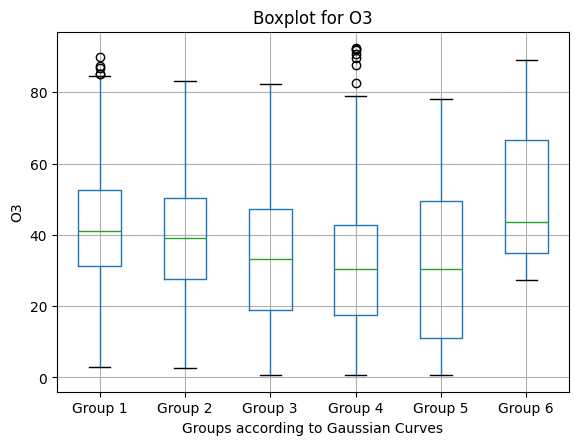

<Figure size 1000x600 with 0 Axes>

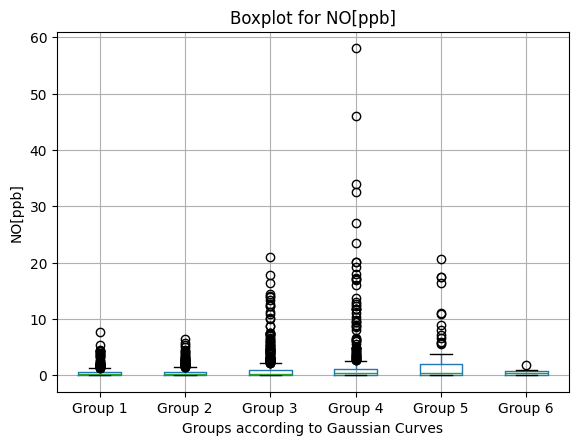

<Figure size 1000x600 with 0 Axes>

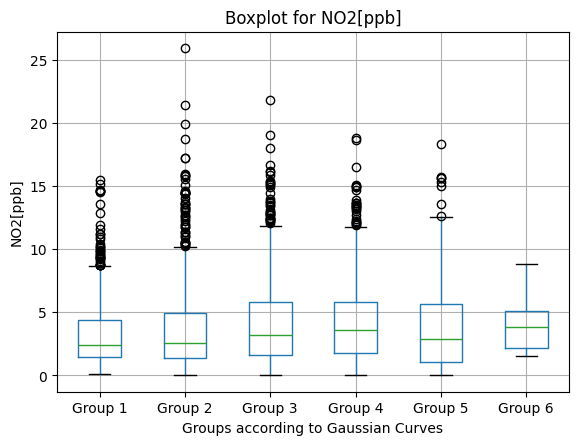

<Figure size 1000x600 with 0 Axes>

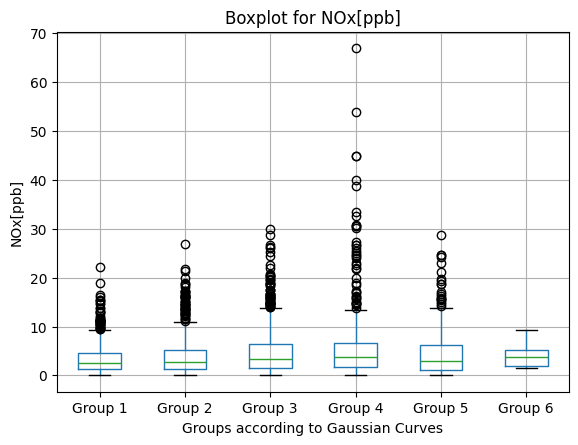

<Figure size 1000x600 with 0 Axes>

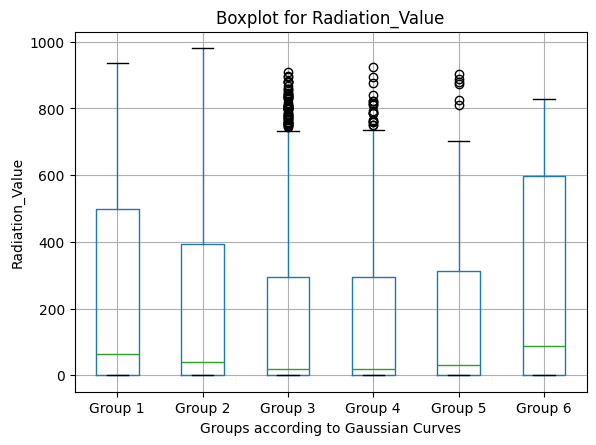

<Figure size 1000x600 with 0 Axes>

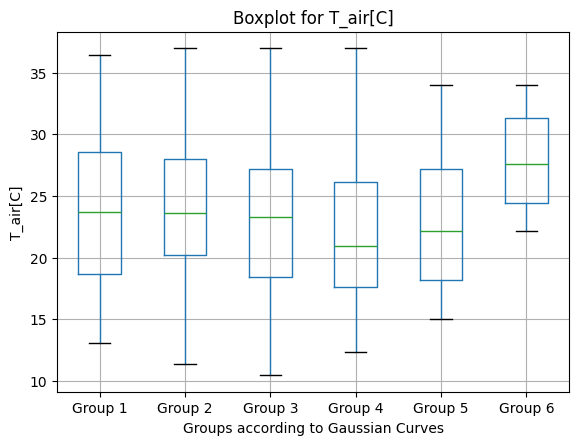

<Figure size 1000x600 with 0 Axes>

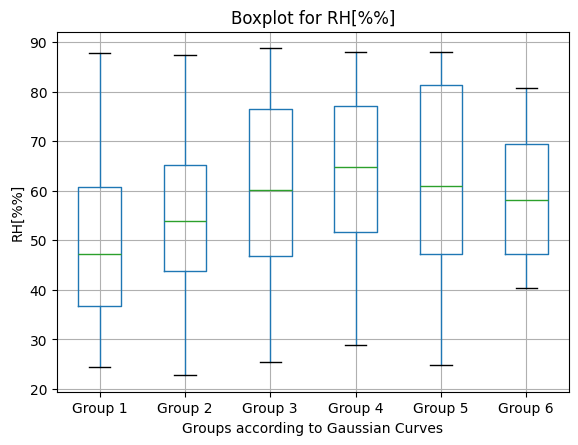

<Figure size 1000x600 with 0 Axes>

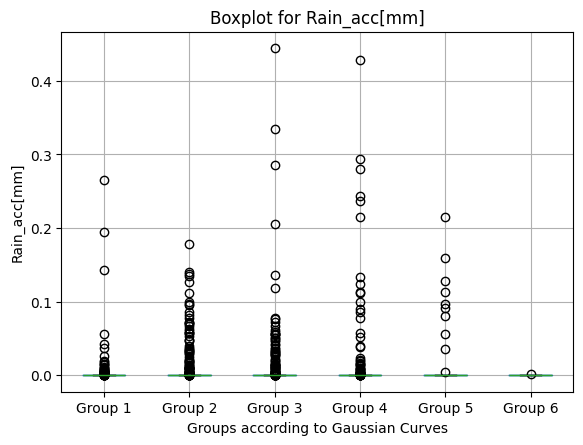

<Figure size 1000x600 with 0 Axes>

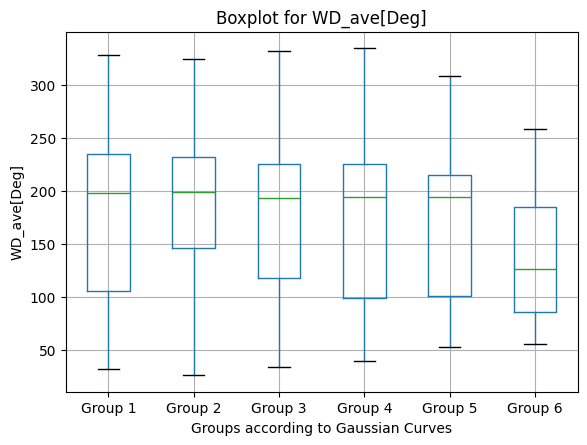

<Figure size 1000x600 with 0 Axes>

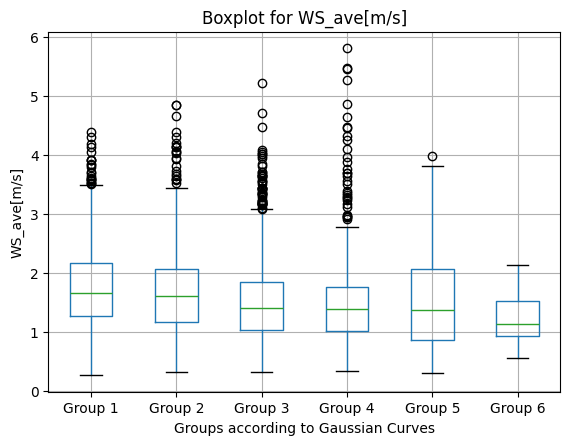

<Figure size 1000x600 with 0 Axes>

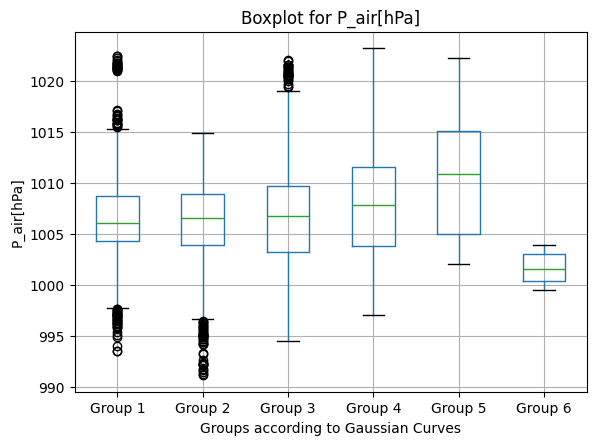

In [259]:
import matplotlib.pyplot as plt

# Plot boxplots for each variable grouped by 'Group'
for column in comp_with_groups.columns[:-1]:  # Exclude the 'Group' column
    plt.figure(figsize=(10, 6))
    comp_with_groups.boxplot(column=column, by='Group', grid=True)
    plt.title(f'Boxplot for {column}')
    plt.suptitle('')  # Remove the default matplotlib subtitle
    plt.ylabel(column)
    plt.xlabel('Groups according to Gaussian Curves')
    plt.show()



### How about BC

In [262]:
# Create a new DataFrame to include group labels
bc_with_groups = bc.copy()  # Keep the original untouched
bc_with_groups['Group'] = {}  # Initialize a 'Group' column

In [263]:
# Normalize index 
bc_dates = bc.index.normalize() # Reduce index to date part

# Rebuild mask
bc_mask1 = bc_dates.isin(group1_dates)
bc_mask2 = bc_dates.isin(group2_dates)
bc_mask3 = bc_dates.isin(group3_dates)
bc_mask4 = bc_dates.isin(group4_dates)
bc_mask5 = bc_dates.isin(group5_dates)
bc_mask6 = bc_dates.isin(group6_dates)


# Assign group labels
bc_with_groups.loc[bc_mask1, 'Group'] = 'Group 1'
bc_with_groups.loc[bc_mask2, 'Group'] = 'Group 2'
bc_with_groups.loc[bc_mask3, 'Group'] = 'Group 3'
bc_with_groups.loc[bc_mask4, 'Group'] = 'Group 4'
bc_with_groups.loc[bc_mask5, 'Group'] = 'Group 5'
bc_with_groups.loc[bc_mask6, 'Group'] = 'Group 6'

# Drop rows without a group (optional, if there are unmatched rows)
bc_with_groups = bc_with_groups.dropna(subset=['Group'])
bc_with_groups


BC6[ng/m3]    Group
datetime                                 
2024-05-18 00:00:00     0.000000  Group 1
2024-05-18 01:00:00     0.000000  Group 1
2024-05-18 02:00:00     0.000000  Group 1
2024-05-18 03:00:00     0.000000  Group 1
2024-05-18 04:00:00     0.000000  Group 1
...                          ...      ...
2024-10-29 19:00:00  4759.050000  Group 4
2024-10-29 20:00:00  3665.400000  Group 4
2024-10-29 21:00:00  3515.616667  Group 4
2024-10-29 22:00:00  2537.033333  Group 4
2024-10-29 23:00:00  2053.483333  Group 4

[3840 rows x 2 columns]

<Figure size 1000x600 with 0 Axes>

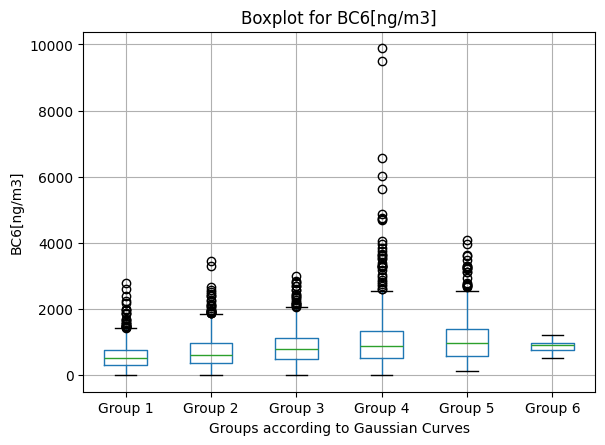

In [264]:
import matplotlib.pyplot as plt

# Plot boxplots for each variable grouped by 'Group'
for column in bc_with_groups.columns[:-1]:  # Exclude the 'Group' column
    plt.figure(figsize=(10, 6))
    bc_with_groups.boxplot(column=column, by='Group', grid=True)
    plt.title(f'Boxplot for {column}')
    plt.suptitle('')  # Remove the default matplotlib subtitle
    plt.ylabel(column)
    plt.xlabel('Groups according to Gaussian Curves')
    plt.show()



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Loop through each variable to create boxplots
for column in comp_with_groups.columns[:-1]:  # Exclude the 'Group' column
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=comp_with_groups, x='Group', y=column)
    plt.title(f'Boxplot for {column}', fontsize=14)
    plt.xlabel('Group', fontsize=12)
    plt.ylabel(column, fontsize=12)
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for better readability
    plt.tight_layout()
    plt.show()